# Numerical Experiments - 5-bus case


## Set up

In [1]:
import numpy as np
import pandas as pd
from math import ceil
from itertools import product
import lropt
from utils import plot_iters, plot_coverage_all
import cvxpy as cp
from cvxpylayers.torch import CvxpyLayer
import torch

# from tqdm.notebook import tqdm, trange
from tqdm import tqdm, trange

import pickle

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.patches import Ellipse
from matplotlib.patches import Rectangle
from matplotlib.patches import Patch
import matplotlib.transforms as transforms
%matplotlib inline

import torch

DTYPE = torch.double
SEED = 42

# experiment default settings
N_DATA = 1000
MAX_EPOCH = 100
TEST_PERC = 0.25
CORR = 0.5

### Power system data

In [39]:
# parameters of matpower case 5

d = np.array([0.0, 3.0, 3.0, 4.0, 0.0])
pmax = np.array([0.4, 1.7, 5.2, 2.0, 6.0])
pmin = np.zeros(len(pmax))
smax = np.array([4.0, 1.9, 2.2, 1.0, 1.0, 2.4])
ptdf_str  = '-0.193917 0.475895   0.348989  0.0  -0.159538;'
ptdf_str += '-0.437588  -0.258343  -0.189451  0.0  -0.36001;'
ptdf_str += '-0.368495  -0.217552  -0.159538  0.0   0.519548;'
ptdf_str += '-0.193917  -0.524105   0.348989  0.0  -0.159538;'
ptdf_str += '-0.193917  -0.524105  -0.651011  0.0  -0.159538;'
ptdf_str += '0.368495   0.217552   0.159538  0.0   0.48045'
ptdf = np.matrix(ptdf_str)
cE = np.array([14.0, 15.0, 30.0, 40.0, 10.0]) # linear cost
cE_quad = np.sqrt(cE * 0.1) # quadratic cost
cR = np.array([80., 80., 15., 30., 80.])
basemva = 100
genloc = np.array([1, 1, 3, 4, 5]) -1
windloc = np.array([3, 5]) - 1  # standard wind farm location
# windloc = np.array([3, 2]) - 1  # configuration B
w = np.array([1.0, 1.5])
w_cap = np.array([2.0, 3.0])
G = len(genloc)
D = len(windloc)
L = ptdf.shape[0]
B = ptdf.shape[1]
gen2bus = np.zeros((B,G))
for g, bus in enumerate(genloc):
    gen2bus[bus, g] = 1
wind2bus = np.zeros((B,D))
for u, bus in enumerate(windloc):
    wind2bus[bus, u] = 1

### Operational model

In [40]:

def box_robust_dcopf_problem_param(mu_init, sigma_init, demand, wind, allow_slack=False, quadratic_cost=False, gamma=0):


    # some settings
    A_base = 10
    slack_base = 10
    obj_base = basemva/10
    
    FR = 0.8 # reduction of line capacity
    
    # define mean and uncertainty of wind power injections as parameters
    mu = cp.Parameter(D, value=mu_init, name="mu")
    sigma = cp.Parameter(D, value=sigma_init, name="sigma")
    
     # define load as a parameter
    d = cp.Parameter(B, value=demand, name="demand")
    w = cp.Parameter(D, value=wind, name="wind")
        
    # main variables
    p  = cp.Variable(G, pos=True, name="p")
    rp = cp.Variable(G, pos=True, name="rp")
    rm = cp.Variable(G, pos=True, name="rm")
    A  = cp.Variable((G,D), pos=True, name="A")
    fRAMp = cp.Variable(L, pos=True, name="fRAMp")
    fRAMm = cp.Variable(L, pos=True, name="fRAMm")

    # aux. variables for robust constraints
    z = cp.Variable((2*G + 2*L,D), name="z")
    
    # aux. variables to ensure feasibility
    if allow_slack:
        slack = cp.Variable(2*G + 2*L, pos=True, name="slack")
    
    # basic det constraints
    flow = ptdf @ ((gen2bus @ p) + (wind2bus @ w) - d)
    consts = [
        cp.sum(p) + cp.sum(w) == cp.sum(d),
        p + rp <= pmax,
        p - rm >= pmin, 
        A.T @ np.ones(G) == np.ones(D)*A_base,
         flow + fRAMp == smax * FR,
        -flow + fRAMm == smax * FR
    ]

    # box support constraints
    for g in range(G):
        if allow_slack:
            consts.append((mu.T @ (-A[g,:]/A_base)) + (sigma.T @ A[g,:]/A_base) <= rp[g] + slack[g]/slack_base)
        else:
            consts.append((mu.T @ (-A[g,:]/A_base)) + (sigma.T @ A[g,:]/A_base) <= rp[g])
        if allow_slack:
            consts.append((mu.T @ (A[g,:]/A_base)) + (sigma.T @  A[g,:]/A_base) <= rm[g] + slack[g+G]/slack_base)
        else:
            consts.append((mu.T @ (A[g,:]/A_base)) + (sigma.T @  A[g,:]/A_base) <= rm[g])
    for l in range(L):
        Bl = cp.reshape(ptdf[l,:] @ (wind2bus - (gen2bus @ A/A_base)), D)
        # Bl = (ptdf[l,:] @ (wind2bus - (gen2bus @ A))).T
        if allow_slack:
            consts.append(mu.T @ Bl + (sigma.T @ z[l,:]) <= fRAMp[l] + slack[2*G+l]/slack_base)
        else:
            consts.append(mu.T @ Bl + (sigma.T @ z[l,:]) <= fRAMp[l])
        consts.append(z[l,:] >= Bl)
        consts.append(z[l,:] >= -Bl)
        if allow_slack:
            consts.append(mu.T @ -Bl + (sigma.T @ z[L+l,:]) <= fRAMm[l] + slack[2*G+L+l]/slack_base)   
        else:
            consts.append(mu.T @ -Bl + (sigma.T @ z[L+l,:]) <= fRAMm[l])
        consts.append(z[L+l,:] >= -Bl)
        consts.append(z[L+l,:] >= Bl)

    # objective
    cost_E = (cE.T @ p)
    if quadratic_cost:
        cost_E_quad = cp.sum_squares(cp.multiply(cE_quad, p))
    else:
        cost_E_quad = 0                         
    cost_R = (cR.T @ (rp + rm))
    objective = cost_E + cost_E_quad + cost_R
    
    if allow_slack:
        thevars = [p, rp, rm, A, fRAMp, fRAMm, z, slack]
    else:
        thevars = [p, rp, rm, A, fRAMp, fRAMm, z]
    x = cp.hstack([v.flatten() for v in thevars])
    regularization = gamma * cp.sum_squares(x)
    objective += regularization
    
    if allow_slack:
        penalty_slack = cp.sum(slack) * obj_base * 1e3
        objective += penalty_slack
    
    theprob = cp.Problem(cp.Minimize(objective), consts)
    
    return theprob, thevars, [d, w, mu, sigma], consts

## LROPT model

In [41]:

def box_robust_dcopf_problem_param_l(mu_init, sigma_init, demand, wind, allow_slack=False, quadratic_cost=False, gamma=0, train = False, traindat = None, inita=None, initb=None, initeps=None, p=np.inf):

    
    # some settings
    A_base = 10
    slack_base = 10
    obj_base = basemva/10
    
    FR = 0.8 # reduction of line capacity

    # define uncertain parameter and support 
    # Dsupp = np.vstack([np.eye(D),-np.eye(D)])
    # dsupp = np.hstack([np.array(mu_init) + np.array(sigma_init), -np.array(mu_init) + np.array(sigma_init)])
    # u = lropt.UncertainParameter(D,
    #                             uncertainty_set=lropt.Ellipsoidal(p=np.inf,
    #                                                         a=np.eye(D), b=-mu_init, rho = np.max(sigma_init), c = Dsupp, d = dsupp))
    if train: 
        u = lropt.UncertainParameter(D,
                                    uncertainty_set=lropt.Ellipsoidal(p=p,
                                                                data=traindat))
        
        # define mean and uncertainty of wind power injections as parameters
        # mu = cp.Parameter(D, value=mu_init, name="mu")
        # sigma = cp.Parameter(D, value=sigma_init, name="sigma")
        
        # define load as a parameter
        d = lropt.Parameter(B, data=demand, name="demand")
        w = lropt.Parameter(D, data=wind, name="wind")
    else: 
        u = lropt.UncertainParameter(D,
                                    uncertainty_set=lropt.Ellipsoidal(p=p,
                                                                a=np.diag(np.array(sigma_init)), b=mu_init, rho = 1))
        d = cp.Parameter(B, value=demand, name="demand")
        w = cp.Parameter(D, value=wind, name="wind")
    if inita is not None:
        u = lropt.UncertainParameter(D,
                                    uncertainty_set=lropt.Ellipsoidal(p=p,
                                                                a=inita, b=initb, rho = initeps))
        
        # define mean and uncertainty of wind power injections as parameters   
        
    # main variables
    p  = cp.Variable(G, pos=True, name="p")
    rp = cp.Variable(G, pos=True, name="rp")
    rm = cp.Variable(G, pos=True, name="rm")
    A  = cp.Variable((G,D), pos=True, name="A")
    fRAMp = cp.Variable(L, pos=True, name="fRAMp")
    fRAMm = cp.Variable(L, pos=True, name="fRAMm")

    # aux. variables for robust constraints
    # z = cp.Variable((2*G + 2*L,D), name="z")
    
    # aux. variables to ensure feasibility
    if allow_slack:
        slack = cp.Variable(2*G + 2*L, pos=True, name="slack")
    
    # basic det constraints
    flow = ptdf @ ((gen2bus @ p) + (wind2bus @ w) - d)
    consts = [
        cp.sum(p) + cp.sum(w) == cp.sum(d),
        p + rp <= pmax,
        p - rm >= pmin, 
        A.T @ np.ones(G) == np.ones(D)*A_base,
         flow + fRAMp == smax * FR,
        -flow + fRAMm == smax * FR
    ]
    # box support constraints
    for g in range(G):
        if allow_slack:
            consts.append((-A[g,:]/A_base)@u <=rp[g] + slack[g]/slack_base )
        else:
            consts.append((-A[g,:]/A_base)@u <=rp[g])
        if allow_slack:
            consts.append(((A[g,:]/A_base))@u <= rm[g] + slack[g+G]/slack_base)
        else:
            consts.append(((A[g,:]/A_base))@u <= rm[g])
    for l in range(L):
        Bl = cp.reshape(ptdf[l,:] @ (wind2bus - (gen2bus @ A/A_base)), D)
        if allow_slack:
            consts.append(Bl@u <= fRAMp[l] + slack[2*G+l]/slack_base)
        else:
            consts.append(Bl@u <= fRAMp[l])
        if allow_slack:
            consts.append(-Bl@u <= fRAMm[l] + slack[2*G+L+l]/slack_base) 
        else:
            consts.append(-Bl@u <= fRAMm[l])

    # objective
    cost_E = (cE.T @ p)
    if quadratic_cost:
        cost_E_quad = cp.sum_squares(cp.multiply(cE_quad, p))
    else:
        cost_E_quad = 0                         
    cost_R = (cR.T @ (rp + rm))
    objective = cost_E + cost_E_quad + cost_R
    
    if allow_slack:
        thevars = [p, rp, rm, A, fRAMp, fRAMm,slack]
    else:
        thevars = [p, rp, rm, A, fRAMp, fRAMm]
    x = cp.hstack([v.flatten() for v in thevars])
    regularization = gamma * cp.sum_squares(x)
    objective += regularization
    
    if allow_slack:
        penalty_slack = cp.sum(slack) * obj_base * 1e3
        objective += penalty_slack
    
    theprob = lropt.RobustProblem(cp.Minimize(objective), consts, eval_exp = objective)
    
    return theprob, thevars, [d, w], consts

In [42]:

def box_robust_dcopf_problem_param_l_max(mu_init, sigma_init, demand, wind, allow_slack=False, quadratic_cost=False, gamma=0, train = False, traindat = None, inita=None, initb=None, initeps=1, p=np.inf, MRO = False, K=1):

    
    # some settings
    A_base = 10
    slack_base = 10
    obj_base = basemva/10
    
    FR = 0.8 # reduction of line capacity

    # define uncertain parameter and support 
    # Dsupp = np.vstack([np.eye(D),-np.eye(D)])
    # dsupp = np.hstack([np.array(mu_init) + np.array(sigma_init), -np.array(mu_init) + np.array(sigma_init)])
    # u = lropt.UncertainParameter(D,
    #                             uncertainty_set=lropt.Ellipsoidal(p=np.inf,
    #                                                         a=np.eye(D), b=-mu_init, rho = np.max(sigma_init), c = Dsupp, d = dsupp))
    if train: 
        u = lropt.UncertainParameter(D,
                                    uncertainty_set=lropt.Ellipsoidal(p=p,a=np.diag(np.array(sigma_init)), b=mu_init,
                                                                data=traindat))
        
        # define mean and uncertainty of wind power injections as parameters
        # mu = cp.Parameter(D, value=mu_init, name="mu")
        # sigma = cp.Parameter(D, value=sigma_init, name="sigma")
        
        # define load as a parameter
        d = lropt.Parameter(B, data=demand, name="demand")
        w = lropt.Parameter(D, data=wind, name="wind")
    else: 
        u = lropt.UncertainParameter(D,
                                    uncertainty_set=lropt.Ellipsoidal(p=p,
                                                                a=np.diag(np.array(sigma_init)), b=mu_init, rho = 1))
        d = cp.Parameter(B, value=demand, name="demand")
        w = cp.Parameter(D, value=wind, name="wind")
    if inita is not None:
        u = lropt.UncertainParameter(D,
                                    uncertainty_set=lropt.Ellipsoidal(p=p,
                                                                a=inita, b=initb, rho = initeps))
        
        # define mean and uncertainty of wind power injections as parameters
        # mu = cp.Parameter(D, value=mu_init, name="mu")
        # sigma = cp.Parameter(D, value=sigma_init, name="sigma")
        
        # define load as a parameter
    if MRO:
        u = lropt.UncertainParameter(D,
                                    uncertainty_set=lropt.MRO(K=K, p=p,
                                                                 rho = initeps, train = train, data=traindat))
        
        
    # main variables
    p  = cp.Variable(G, pos=True, name="p")
    rp = cp.Variable(G, pos=True, name="rp")
    rm = cp.Variable(G, pos=True, name="rm")
    A  = cp.Variable((G,D), pos=True, name="A")
    fRAMp = cp.Variable(L, pos=True, name="fRAMp")
    fRAMm = cp.Variable(L, pos=True, name="fRAMm")

    # aux. variables for robust constraints
    # z = cp.Variable((2*G + 2*L,D), name="z")
    
    # aux. variables to ensure feasibility
    if allow_slack:
        slack = cp.Variable(2*G + 2*L, pos=True, name="slack")
    
    # basic det constraints
    flow = ptdf @ ((gen2bus @ p) + (wind2bus @ w) - d)
    consts = [
        cp.sum(p) + cp.sum(w) == cp.sum(d),
        p + rp <= pmax,
        p - rm >= pmin, 
        A.T @ np.ones(G) == np.ones(D)*A_base,
         flow + fRAMp == smax * FR,
        -flow + fRAMm == smax * FR
    ]
    maxcons = []
    # box support constraints
    for g in range(G):
        if allow_slack:
            maxcons.append((-A[g,:]/A_base)@u - rp[g] - slack[g]/slack_base )
        else:
            maxcons.append((-A[g,:]/A_base)@u - rp[g])
        if allow_slack:
            maxcons.append(((A[g,:]/A_base))@u- rm[g] - slack[g+G]/slack_base)
        else:
            maxcons.append(((A[g,:]/A_base))@u - rm[g])
    for l in range(L):
        Bl = cp.reshape(ptdf[l,:] @ (wind2bus - (gen2bus @ A/A_base)), D)
        if allow_slack:
            maxcons.append(Bl@u- fRAMp[l] - slack[2*G+l]/slack_base)
        else:
            maxcons.append(Bl@u - fRAMp[l])
        if allow_slack:
            maxcons.append(-Bl@u - fRAMm[l] - slack[2*G+L+l]/slack_base) 
        else:
            maxcons.append(-Bl@u -  fRAMm[l])
    
    consts.append(cp.maximum(*maxcons)<=0)

    # objective
    cost_E = (cE.T @ p)
    if quadratic_cost:
        cost_E_quad = cp.sum_squares(cp.multiply(cE_quad, p))
    else:
        cost_E_quad = 0                         
    cost_R = (cR.T @ (rp + rm))
    objective = cost_E + cost_E_quad + cost_R
    
    if allow_slack:
        thevars = [p, rp, rm, A, fRAMp, fRAMm,slack]
    else:
        thevars = [p, rp, rm, A, fRAMp, fRAMm]
    x = cp.hstack([v.flatten() for v in thevars])
    regularization = gamma * cp.sum_squares(x)
    objective += regularization
    
    if allow_slack:
        penalty_slack = cp.sum(slack) * obj_base * 1e3
        objective += penalty_slack
    
    theprob = lropt.RobustProblem(cp.Minimize(objective), consts, eval_exp = objective)
    
    return theprob, thevars, [d, w], consts

### Error data

In [43]:
def create_historical_data(w_fcst, N=1000, SEED=42, metadata=False, corr=0.1, rel_sigma=[0.15, 0.15]):
    mu = np.zeros(D)
    rel_sigma = np.array(rel_sigma)
    correlation = np.matrix([[1.0, corr],[corr, 1.0]])
    sigma = w_fcst * rel_sigma
    Sigma = np.diag(sigma)*correlation*np.diag(sigma)
    # sample
    # np.random.seed(seed=SEED)
    hist_data = np.random.multivariate_normal(mu, Sigma, size=N)
    # truncate
    for j in range(D):
        hist_data[(hist_data[:,j] >= w_cap[j] - w_fcst[j]),j] = w_cap[j] - w_fcst[j]
        hist_data[(hist_data[:,j] <= -w_fcst[j]),j] = -w_fcst[j]
    if metadata:
        return hist_data, mu, Sigma
    else:
        return hist_data

In [44]:

TEST_PERC = 0.25
CORR = 0.5

# reset randomness
np.random.seed(seed=10)

# some other settings
d_range = [0.5, 1.1]
w_range = [0.5, 1.1]

# define bins
nbins = 10
bins = [np.linspace(w_range[0]*w[i], w_range[1]*w[i], nbins+1) for i in range(D)]

# create a large set of forecast errors from different wind scenarios
N_samples = 100
train_errors_in_bins = [[[] for bi in range(nbins+3)] for i in range(D)]
all_errors = []
for i in trange(N_samples):
    d_scenario_np = np.random.uniform(*d_range, B) * d
    w_scenario_np = np.random.uniform(*w_range, D) * w
    cur_data = create_historical_data(w_scenario_np, N=1, corr=CORR)[0]
    for i in range(D):
        cur_bin = np.digitize(w_scenario_np[i], bins[i])
        train_errors_in_bins[i][cur_bin].append(cur_data[i])
    all_errors.append(cur_data)
all_errors = np.vstack(all_errors)

train, test = train_test_split(all_errors, test_size=int(all_errors.shape[0]*TEST_PERC), random_state=SEED)

train_data = torch.tensor(train, dtype=DTYPE)
test_data = torch.tensor(test, dtype=DTYPE)

# init based on stdv
mu_init = np.mean(train, axis=0)
sigma_init =np.std(train, axis=0)/2

# percentile-based set paramters
perc= 10 # in percent
percupper = np.percentile(train, 100-perc, axis=0)
perclower = np.percentile(train, perc, axis=0)
mu_base_perc = (percupper + perclower) / 2
sigma_base_perc = mu_init + ((percupper - perclower) / 2)

100%|██████████| 100/100 [00:00<00:00, 3868.04it/s]


### Model test

In [45]:
prob, _, theparams, _ = box_robust_dcopf_problem_param(mu_init, sigma_init, d, w, allow_slack=False, quadratic_cost=True)
prob.solve(solver="CLARABEL")

194.96053978311474

## LROPT model test

In [46]:
prob_lropt, thevarslropt, theparamslropt, _ = box_robust_dcopf_problem_param_l(mu_init, sigma_init, d, w, allow_slack=False, quadratic_cost=True)
prob_lropt.solve(solver="CLARABEL")

194.96054291980278

In [47]:
prob_lroptmax, thevarslroptmax, theparamslroptmax, _ = box_robust_dcopf_problem_param_l_max(mu_init, sigma_init, d, w, allow_slack=False, quadratic_cost=True)
prob_lroptmax.solve(solver="CLARABEL")

194.96054291980278

In [48]:
# test feasibility for a few random scenarios
#0.5-1.1
# can change range 0.8
d_range = [1, 1]
w_range = [1, 1]
d_scenario = np.random.uniform(*d_range, B) * d
w_scenario = np.random.uniform(*w_range, D) * w

theparams[0].value = d_scenario
theparams[1].value = w_scenario
prob.solve(solver="CLARABEL")
# print(prob.status)
print(f'Objective value:  {prob.objective.value:.4f}') 

Objective value:  194.9605


In [49]:
theparamslropt[0].value = d_scenario
theparamslropt[1].value = w_scenario
prob_lropt.solve(solver="CLARABEL")
print(f'Objective value:  {prob_lropt.objective.value:.4f}') 
theparamslroptmax[0].value = d_scenario
theparamslroptmax[1].value = w_scenario
prob_lroptmax.solve(solver="CLARABEL")
print(f'Objective value:  {prob_lroptmax.objective.value:.4f}') 

Objective value:  194.9605
Objective value:  194.9605


## LROPT Training

In [50]:
# Generate a batch of scenarios for d and w
def gen_dw_data(num, d,w, seed=SEED):
    d_dat = d 
    w_dat = w
    for i in range(num-1):
        d_scenario = np.random.uniform(*d_range, B) * d
        w_scenario = np.random.uniform(*w_range, D) * w
        d_dat = np.vstack([d_dat,d_scenario])
        w_dat = np.vstack([w_dat, w_scenario])
    return d_dat, w_dat

d_dat, w_dat = gen_dw_data(int(N_samples*(1-TEST_PERC)),d,w)
init_aval = np.diag(np.array(sigma_init))
init_bval =mu_init

In [52]:
prob_lropt, thevarslropt, theparamslropt, _ = box_robust_dcopf_problem_param_l_max(mu_init, sigma_init, d_dat, w_dat, allow_slack=False, quadratic_cost=True, train=True, traindat=train, p=2, MRO=True, K=5, initeps=0.1)

init_aval = np.diag(np.array(sigma_init))
init_bval = mu_init
init_aval = np.eye(2)
init_bval = np.zeros(2)
# np.random.seed(0)
# init_aval = 0.5*np.random.rand(2,2)+np.eye(2)
# init_bval = -init_aval@mu_init

result = prob_lropt.train(init_eps = 1.3, lr = 0.000001,num_iter=1000, optimizer = "SGD", seed = SEED+1, init_A =init_aval, init_b = init_bval, init_lam = 50, init_mu = 10, mu_multiplier=1.01, init_alpha = -0.0, test_percentage = TEST_PERC, save_history = False, lr_step_size = 100, lr_gamma = 0.5, position = False, random_init = False, num_random_init=5, parallel = False, kappa=0., eta=0.3)

/Users/irina.wang/anaconda3/envs/lropt_s/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/anaconda3/envs/lropt_s/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
 

In [53]:
result_mvar = prob_lropt.grid(epslst = np.linspace(0.0001,2, 10), init_A = init_aval, init_b = init_bval, seed = SEED, init_alpha = 0., test_percentage = TEST_PERC)
dfgrid = result_mvar.df

In [54]:
result_reshape = prob_lropt.grid(epslst = np.linspace(0.0001,2, 10), init_A = result.A, init_b = result.b, seed = SEED, init_alpha = 0., test_percentage = 
TEST_PERC)
dfgrid2 = result_reshape.df

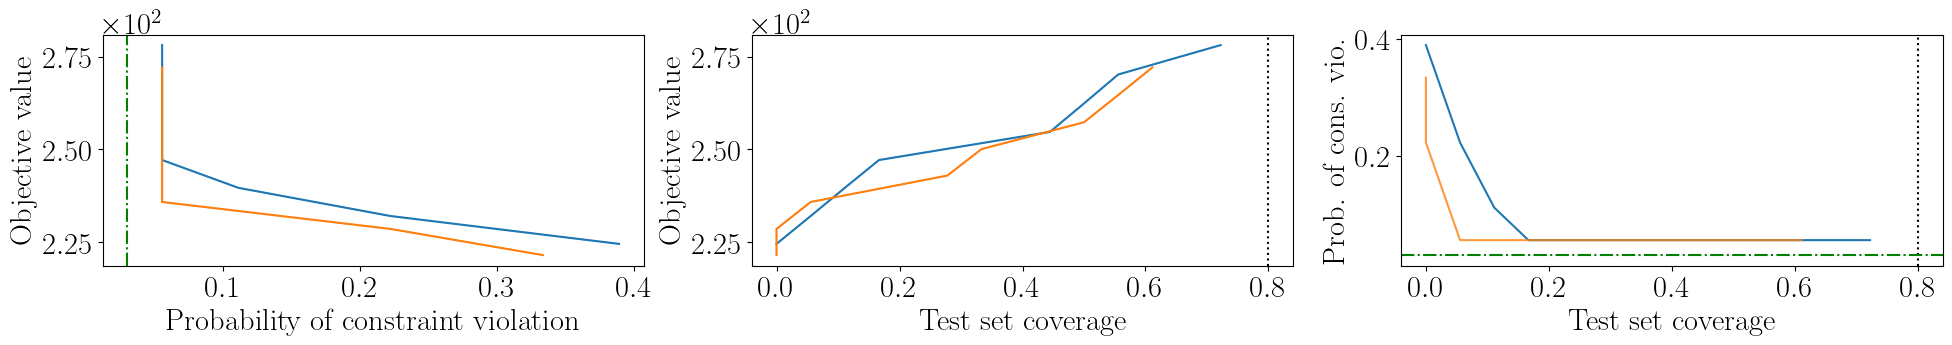

In [64]:
plot_coverage_all(dfgrid,dfgrid2,None, "energy",ind_1=(1,9),ind_2=(1,9), logscale = False)

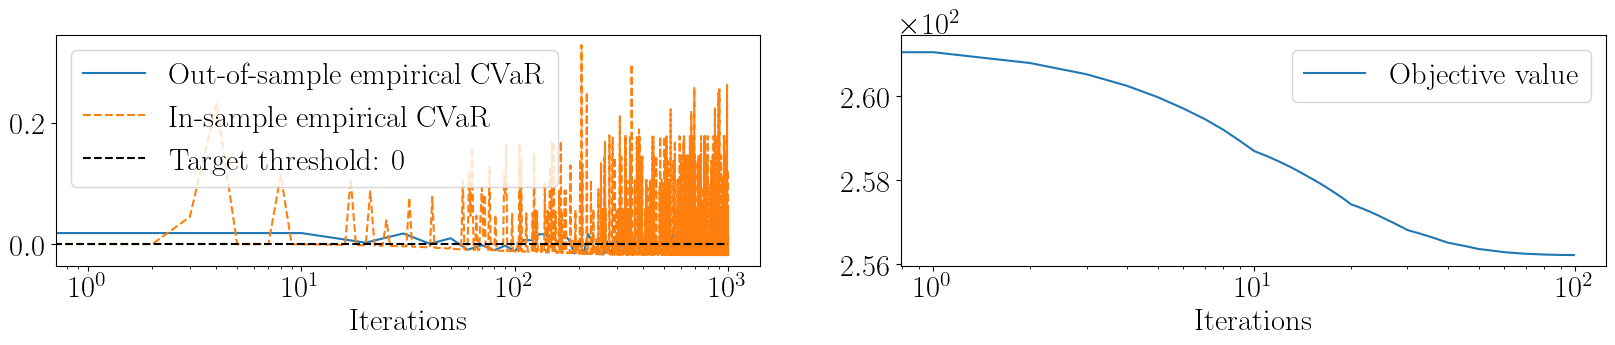

In [56]:
plot_iters(result.df, result.df_test,"energy", logscale = True, steps = 1000)

Text(0, 0.5, 'Values')

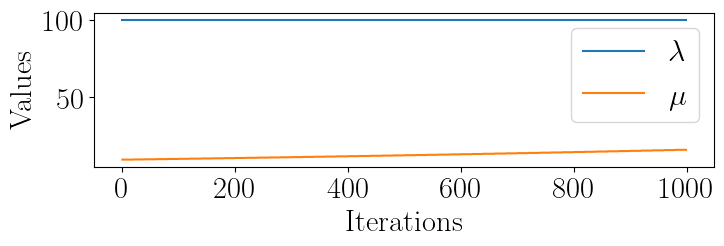

In [28]:
plt.figure(figsize=(8,2))
plt.plot(np.arange(result.df.shape[0]),np.hstack(result.df['lam_list']), label = r"$\lambda$")
plt.plot(np.arange(result.df.shape[0]),result.df['mu'], label = r"$\mu$")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Values")
# plt.yscale("log")

/Users/irina.wang/anaconda3/envs/lropt_s/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/anaconda3/envs/lropt_s/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
 

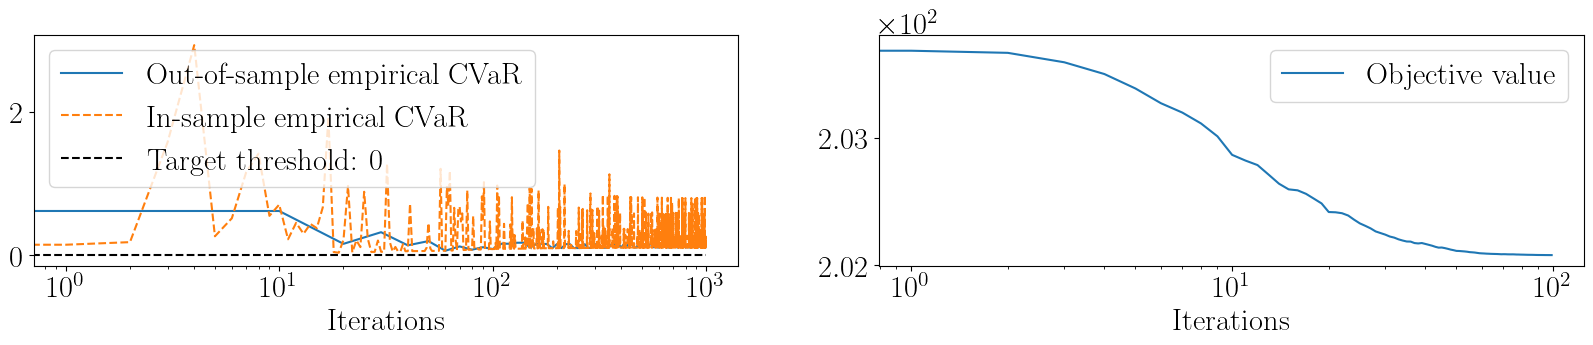

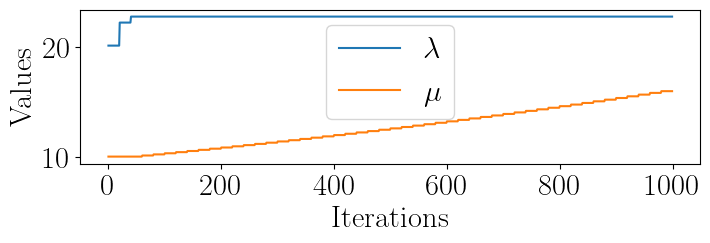

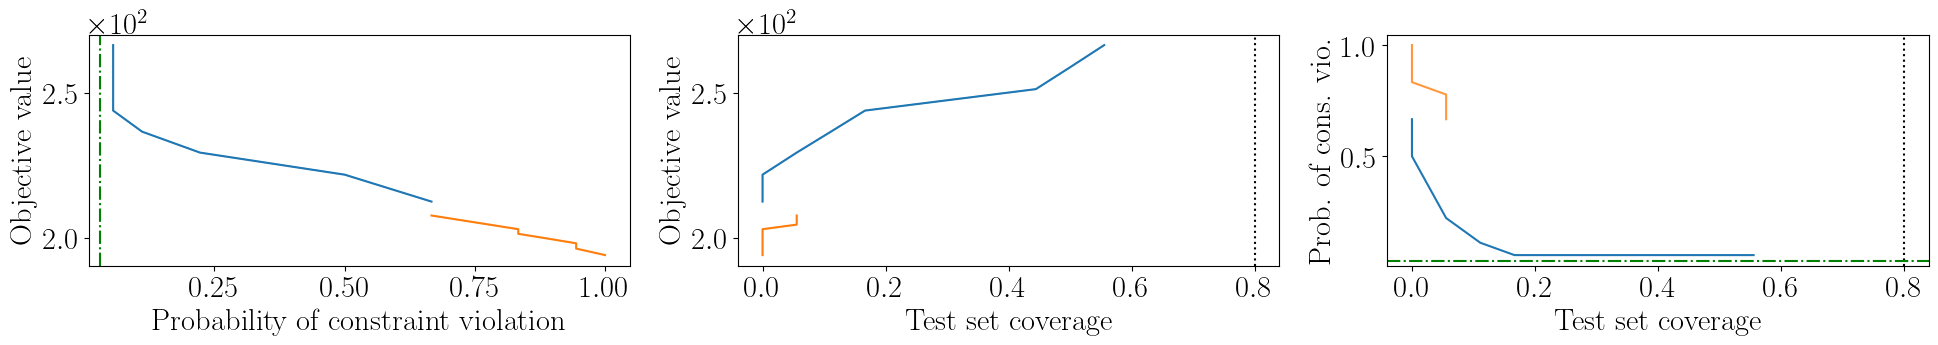

In [22]:
prob_lropt, thevarslropt, theparamslropt, _ = box_robust_dcopf_problem_param_l_max(mu_init, sigma_init, d_dat, w_dat, allow_slack=False, quadratic_cost=True, train=True, traindat=train, p=2, MRO=True, K=5, initeps=0.1)

init_aval = np.diag(np.array(sigma_init))
init_bval = mu_init

init_aval = np.eye(2)
init_bval = np.zeros(2)
# np.random.seed(0)
# init_aval = 0.5*np.random.rand(2,2)+np.eye(2)
# init_bval = -init_aval@mu_init

result2 = prob_lropt.train(init_eps = 1, lr = 0.000001,num_iter=1000, optimizer = "SGD", seed = SEED+1, init_A =0.3*init_aval, init_b = init_bval, init_lam = 10, init_mu = 10, mu_multiplier=1.01, init_alpha = -0.0, test_percentage = TEST_PERC, save_history = False, lr_step_size = 100, lr_gamma = 0.5, position = False, random_init = False, num_random_init=5, parallel = False, kappa=0., eta=0.05)

result_reshape2 = prob_lropt.grid(epslst = np.linspace(0.01,2, 10), init_A = result2.A, init_b = result2.b, seed = SEED, init_alpha = 0., test_percentage = 
TEST_PERC)
dfgrid22 = result_reshape2.df

plot_iters(result2.df, result2.df_test,"energy", logscale = True, steps = 1000)

plt.figure(figsize=(8,2))
plt.plot(np.arange(result2.df.shape[0]),np.hstack(result2.df['lam_list']), label = r"$\lambda$")
plt.plot(np.arange(result2.df.shape[0]),result2.df['mu'], label = r"$\mu$")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Values")
# plt.yscale("log")

plot_coverage_all(dfgrid,dfgrid22,None, "energy",ind_1=(0,8),ind_2=(0,9), logscale = False)

/Users/irina.wang/anaconda3/envs/lropt_s/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/anaconda3/envs/lropt_s/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
 

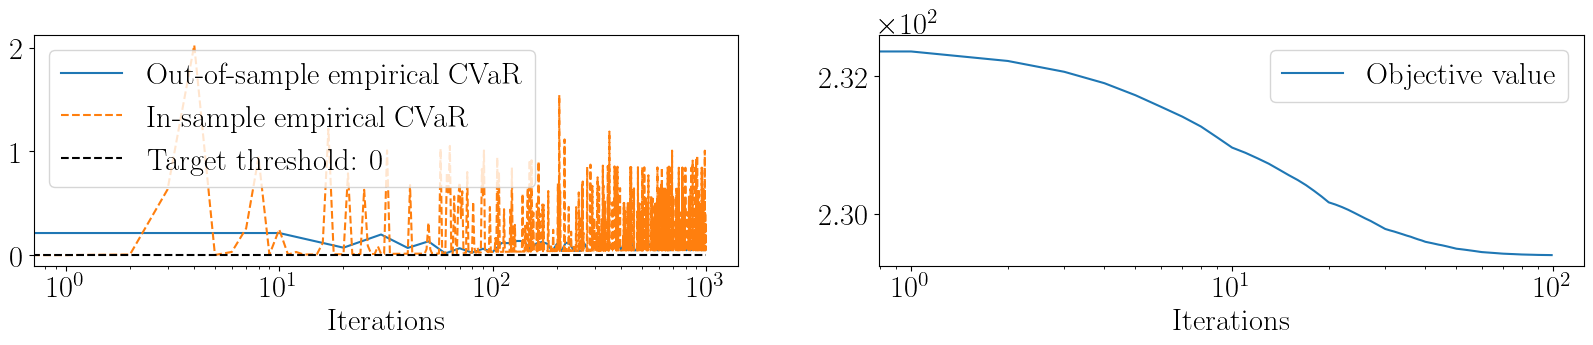

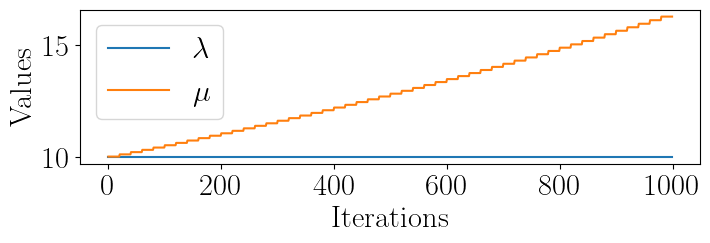

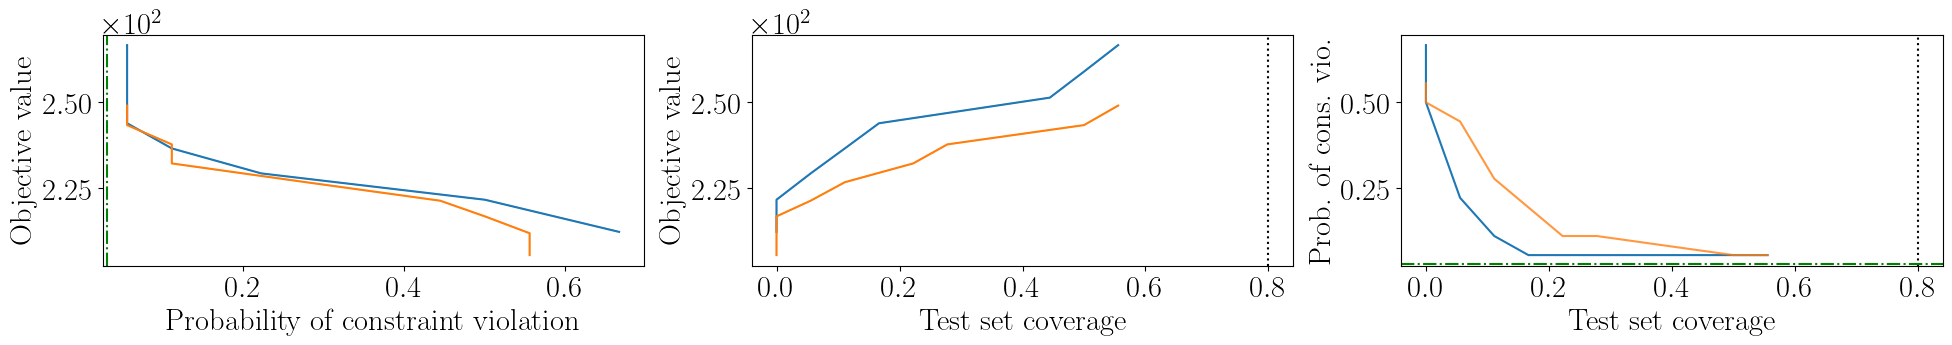

In [23]:
prob_lropt, thevarslropt, theparamslropt, _ = box_robust_dcopf_problem_param_l_max(mu_init, sigma_init, d_dat, w_dat, allow_slack=False, quadratic_cost=True, train=True, traindat=train, p=2, MRO=True, K=5, initeps=0.1)

init_aval = np.diag(np.array(sigma_init))
init_bval = mu_init

init_aval = np.eye(2)
init_bval = np.zeros(2)
# np.random.seed(0)
# init_aval = 0.5*np.random.rand(2,2)+np.eye(2)
# init_bval = -init_aval@mu_init

result3 = prob_lropt.train(init_eps = 1, lr = 0.000001,num_iter=1000, optimizer = "SGD", seed = SEED+1, init_A =0.8*init_aval, init_b = init_bval, init_lam = 10, init_mu = 10, mu_multiplier=1.01, init_alpha = -0.0, test_percentage = TEST_PERC, save_history = False, lr_step_size = 100, lr_gamma = 0.5, position = False, random_init = False, num_random_init=5, parallel = False, kappa=0., eta=0.05)

result_reshape3 = prob_lropt.grid(epslst = np.linspace(0.01,2, 10), init_A = result3.A, init_b = result3.b, seed = SEED, init_alpha = 0., test_percentage = 
TEST_PERC)
dfgrid23 = result_reshape3.df

plot_iters(result3.df, result3.df_test,"energy", logscale = True, steps = 1000)

plt.figure(figsize=(8,2))
plt.plot(np.arange(result3.df.shape[0]),np.hstack(result3.df['lam_list']), label = r"$\lambda$")
plt.plot(np.arange(result3.df.shape[0]),result3.df['mu'], label = r"$\mu$")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Values")
# plt.yscale("log")

plot_coverage_all(dfgrid,dfgrid23,None, "energy",ind_1=(0,8),ind_2=(0,9), logscale = False)

/Users/irina.wang/anaconda3/envs/lropt_s/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/anaconda3/envs/lropt_s/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
 

NameError: name 'dfgrid' is not defined

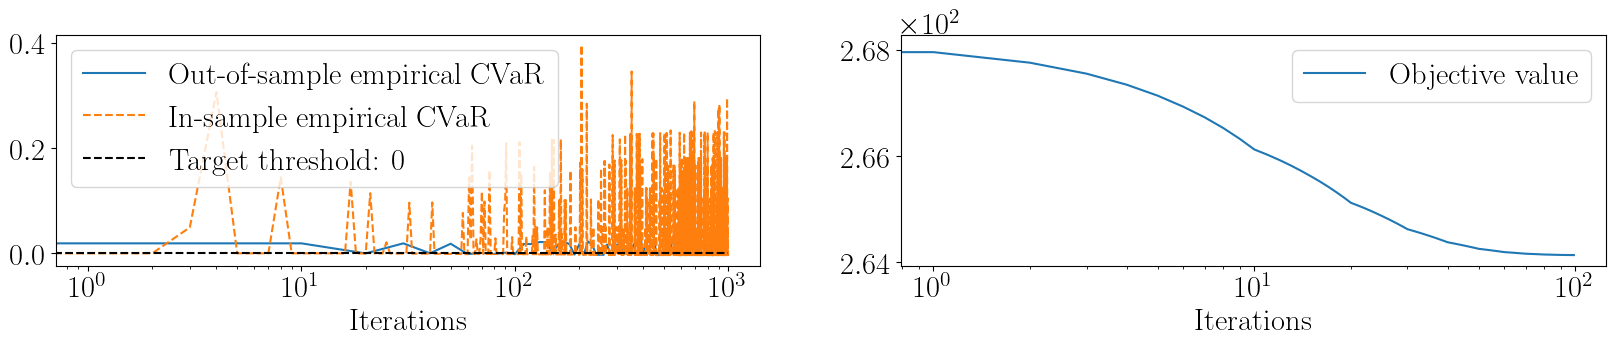

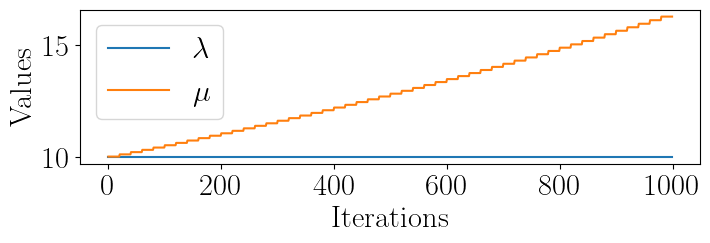

In [14]:
prob_lropt, thevarslropt, theparamslropt, _ = box_robust_dcopf_problem_param_l_max(mu_init, sigma_init, d_dat, w_dat, allow_slack=False, quadratic_cost=True, train=True, traindat=train, p=2, MRO=True, K=5, initeps=0.1)

init_aval = np.diag(np.array(sigma_init))
init_bval = mu_init

init_aval = np.eye(2)
init_bval = np.zeros(2)
# np.random.seed(0)
# init_aval = 0.5*np.random.rand(2,2)+np.eye(2)
# init_bval = -init_aval@mu_init

result4 = prob_lropt.train(init_eps = 1, lr = 0.000001,num_iter=1000, optimizer = "SGD", seed = SEED+1, init_A =1.3*init_aval, init_b = init_bval, init_lam = 10, init_mu = 10, mu_multiplier=1.01, init_alpha = -0.0, test_percentage = TEST_PERC, save_history = False, lr_step_size = 100, lr_gamma = 0.5, position = False, random_init = False, num_random_init=5, parallel = False, kappa=0., eta=0.2)

result_reshape4 = prob_lropt.grid(epslst = np.linspace(0.01,2, 10), init_A = result4.A, init_b = result4.b, seed = SEED, init_alpha = 0., test_percentage = 
TEST_PERC)
dfgrid24 = result_reshape4.df

plot_iters(result4.df, result4.df_test,"energy", logscale = True, steps = 1000)

plt.figure(figsize=(8,2))
plt.plot(np.arange(result4.df.shape[0]),np.hstack(result4.df['lam_list']), label = r"$\lambda$")
plt.plot(np.arange(result4.df.shape[0]),result4.df['mu'], label = r"$\mu$")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Values")
# plt.yscale("log")

plot_coverage_all(dfgrid,dfgrid24,None, "energy",ind_1=(0,8),ind_2=(0,8), logscale = False)

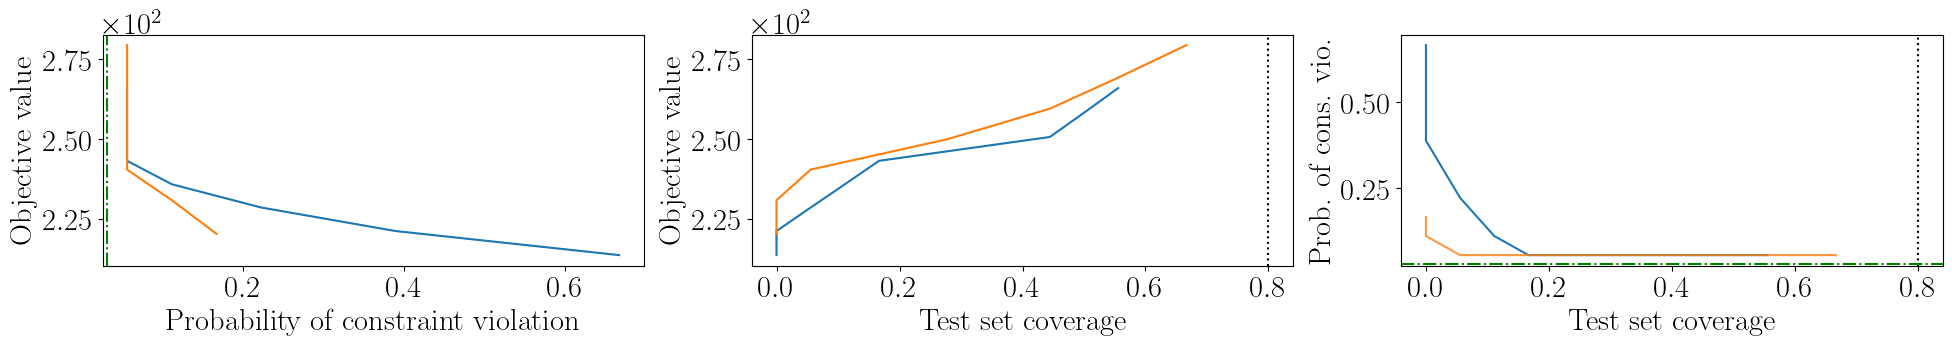

In [17]:
plot_coverage_all(dfgrid,dfgrid24,None, "energy",ind_1=(0,8),ind_2=(0,7), logscale = False)

/Users/irina.wang/anaconda3/envs/lropt_s/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/anaconda3/envs/lropt_s/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
 

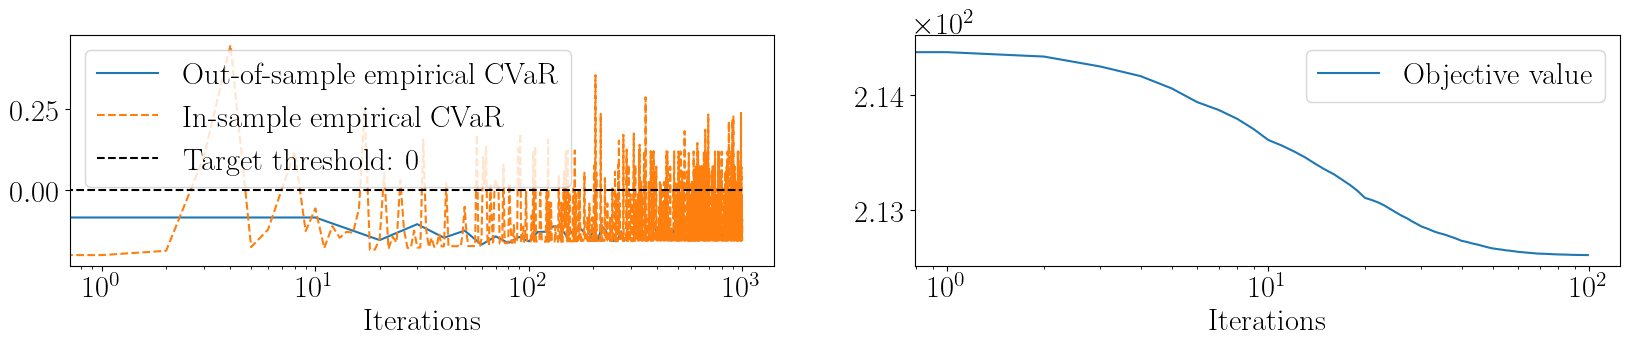

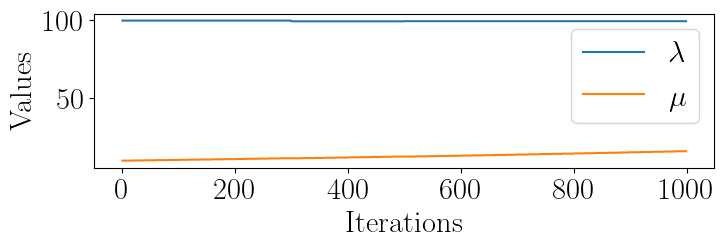

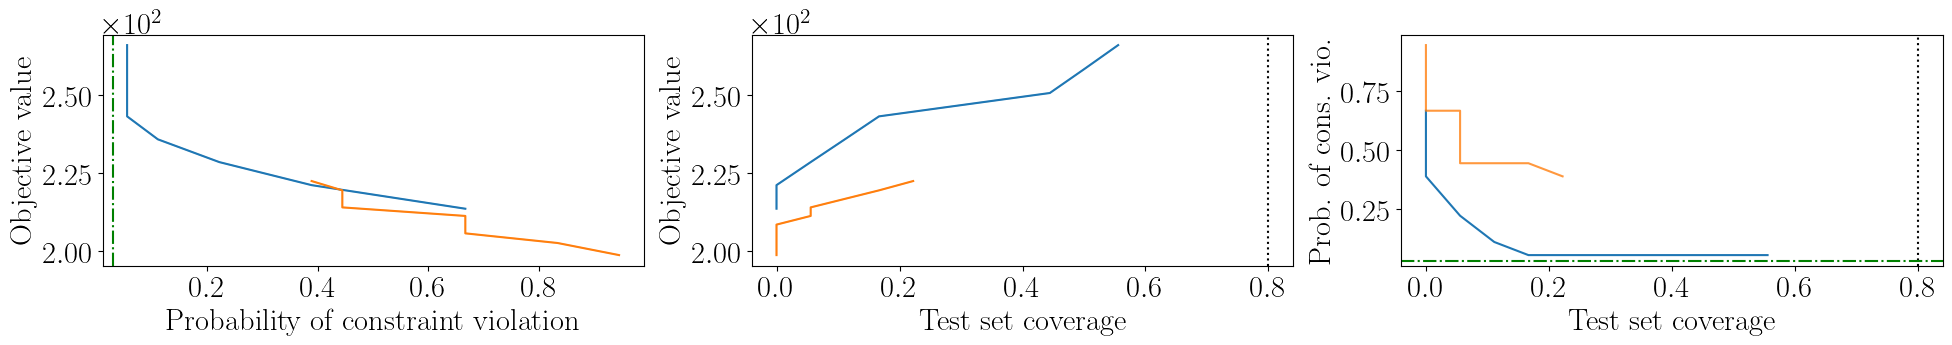

In [18]:
prob_lropt, thevarslropt, theparamslropt, _ = box_robust_dcopf_problem_param_l_max(mu_init, sigma_init, d_dat, w_dat, allow_slack=False, quadratic_cost=True, train=True, traindat=train, p=2, MRO=True, K=5, initeps=0.1)

init_aval = np.diag(np.array(sigma_init))
init_bval = mu_init

init_aval = np.eye(2)
init_bval = np.zeros(2)
# np.random.seed(0)
# init_aval = 0.5*np.random.rand(2,2)+np.eye(2)
# init_bval = -init_aval@mu_init

result5 = prob_lropt.train(init_eps = 1, lr = 0.000001,num_iter=1000, optimizer = "SGD", seed = SEED+1, init_A =0.5*init_aval, init_b = init_bval, init_lam = 100, init_mu = 10, mu_multiplier=1.01, init_alpha = -0.0, test_percentage = TEST_PERC, save_history = False, lr_step_size = 100, lr_gamma = 0.5, position = False, random_init = False, num_random_init=5, parallel = False, kappa=0.2, eta=0.2)

result_reshape5 = prob_lropt.grid(epslst = np.linspace(0.01,2, 10), init_A = result5.A, init_b = result5.b, seed = SEED, init_alpha = 0., test_percentage = 
TEST_PERC)
dfgrid25 = result_reshape5.df

plot_iters(result5.df, result5.df_test,"energy", logscale = True, steps = 1000)

plt.figure(figsize=(8,2))
plt.plot(np.arange(result5.df.shape[0]),np.hstack(result5.df['lam_list']), label = r"$\lambda$")
plt.plot(np.arange(result5.df.shape[0]),result5.df['mu'], label = r"$\mu$")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Values")
# plt.yscale("log")

plot_coverage_all(dfgrid,dfgrid25,None, "energy",ind_1=(0,8),ind_2=(0,9), logscale = False)

/Users/irina.wang/anaconda3/envs/lropt_s/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/anaconda3/envs/lropt_s/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
 

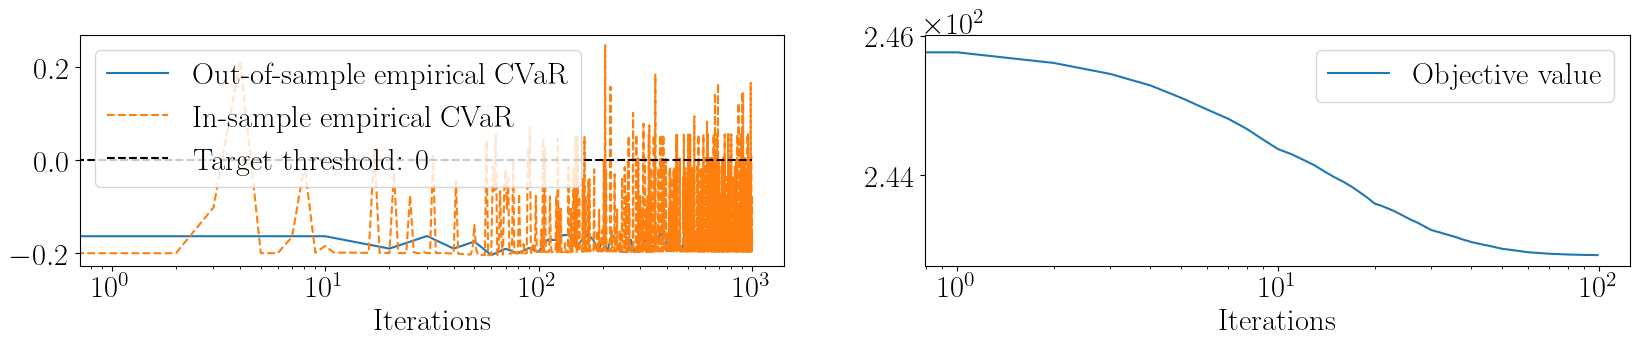

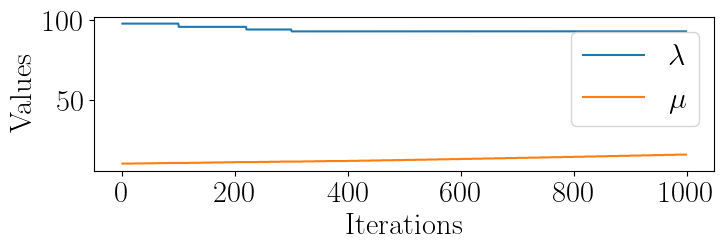

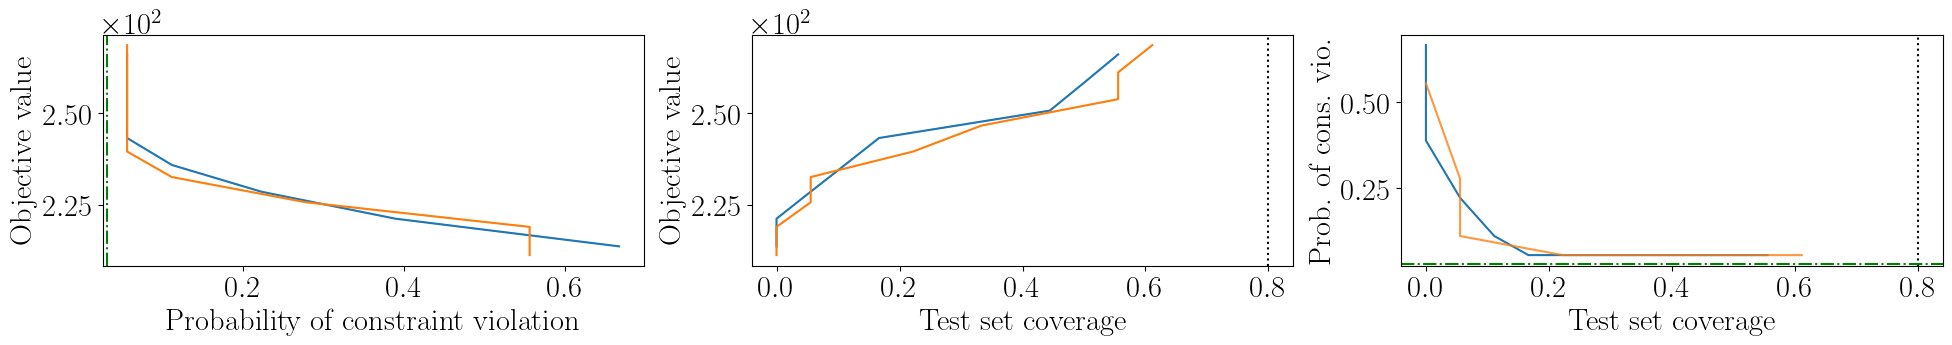

In [19]:
prob_lropt, thevarslropt, theparamslropt, _ = box_robust_dcopf_problem_param_l_max(mu_init, sigma_init, d_dat, w_dat, allow_slack=False, quadratic_cost=True, train=True, traindat=train, p=2, MRO=True, K=5, initeps=0.1)

init_aval = np.diag(np.array(sigma_init))
init_bval = mu_init

init_aval = np.eye(2)
init_bval = np.zeros(2)
# np.random.seed(0)
# init_aval = 0.5*np.random.rand(2,2)+np.eye(2)
# init_bval = -init_aval@mu_init

result6 = prob_lropt.train(init_eps = 1, lr = 0.000001,num_iter=1000, optimizer = "SGD", seed = SEED+1, init_A =init_aval, init_b = init_bval, init_lam = 100, init_mu = 10, mu_multiplier=1.01, init_alpha = -0.0, test_percentage = TEST_PERC, save_history = False, lr_step_size = 100, lr_gamma = 0.5, position = False, random_init = False, num_random_init=5, parallel = False, kappa=0.2, eta=0.2)

result_reshape6 = prob_lropt.grid(epslst = np.linspace(0.01,2, 10), init_A = result6.A, init_b = result6.b, seed = SEED, init_alpha = 0., test_percentage = 
TEST_PERC)
dfgrid26 = result_reshape6.df

plot_iters(result6.df, result6.df_test,"energy", logscale = True, steps = 1000)

plt.figure(figsize=(8,2))
plt.plot(np.arange(result6.df.shape[0]),np.hstack(result6.df['lam_list']), label = r"$\lambda$")
plt.plot(np.arange(result6.df.shape[0]),result6.df['mu'], label = r"$\mu$")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Values")
# plt.yscale("log")

plot_coverage_all(dfgrid,dfgrid26,None, "energy",ind_1=(0,8),ind_2=(0,9), logscale = False)

/Users/irina.wang/anaconda3/envs/lropt_s/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/anaconda3/envs/lropt_s/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
 

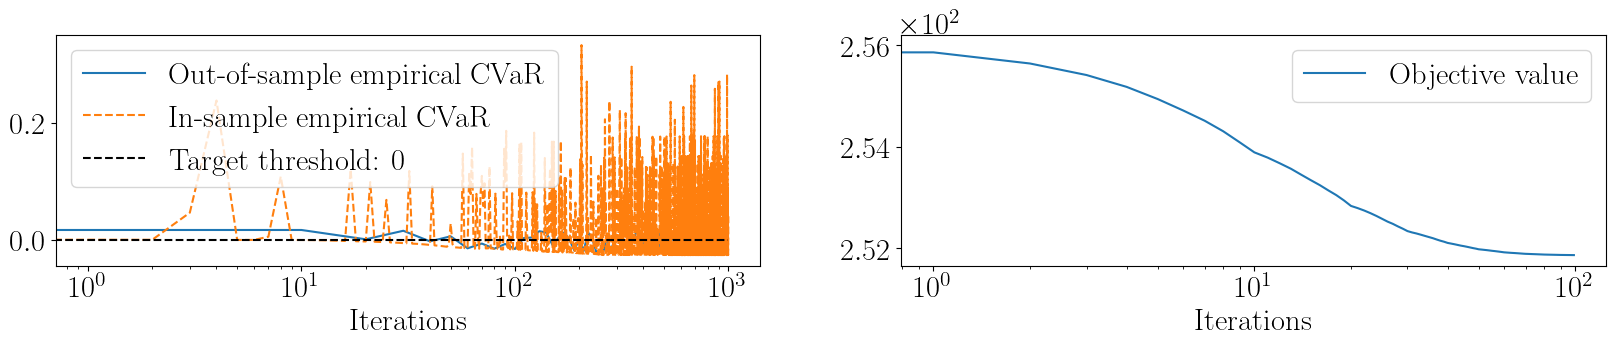

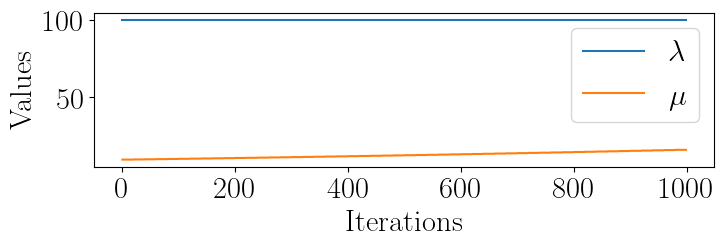

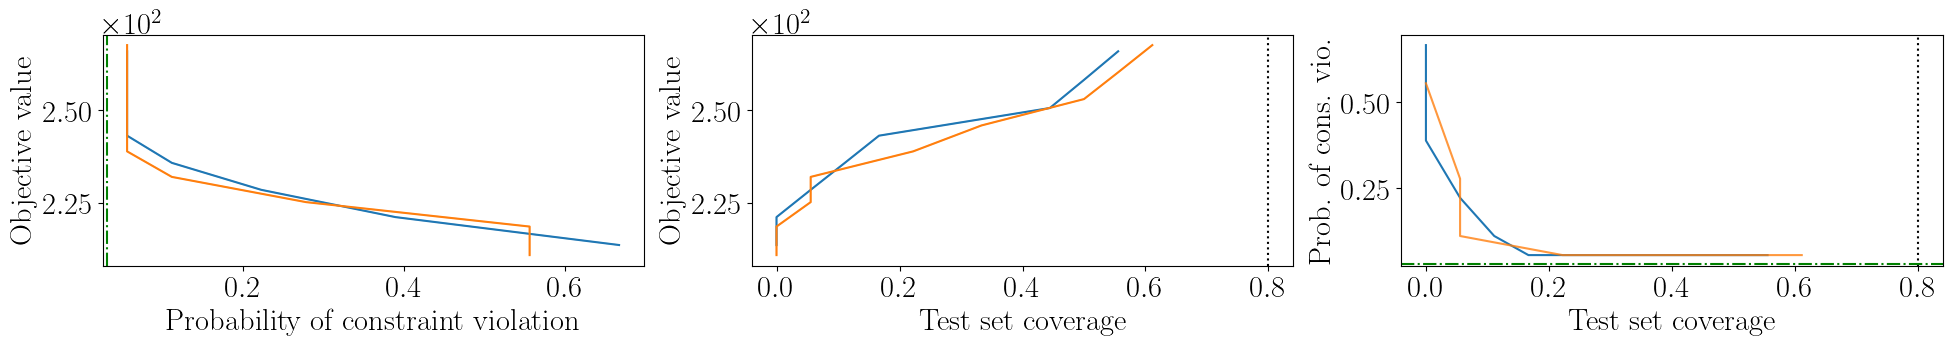

In [21]:
prob_lropt, thevarslropt, theparamslropt, _ = box_robust_dcopf_problem_param_l_max(mu_init, sigma_init, d_dat, w_dat, allow_slack=False, quadratic_cost=True, train=True, traindat=train, p=2, MRO=True, K=5, initeps=0.1)

init_aval = np.diag(np.array(sigma_init))
init_bval = mu_init

init_aval = np.eye(2)
init_bval = np.zeros(2)
# np.random.seed(0)
# init_aval = 0.5*np.random.rand(2,2)+np.eye(2)
# init_bval = -init_aval@mu_init

result7 = prob_lropt.train(init_eps = 1.3, lr = 0.000001,num_iter=1000, optimizer = "SGD", seed = SEED+1, init_A =init_aval, init_b = init_bval, init_lam = 100, init_mu = 10, mu_multiplier=1.01, init_alpha = -0.0, test_percentage = TEST_PERC, save_history = False, lr_step_size = 100, lr_gamma = 0.5, position = False, random_init = False, num_random_init=5, parallel = False, kappa=0., eta=0.3)

result_reshape7 = prob_lropt.grid(epslst = np.linspace(0.01,2, 10), init_A = result7.A, init_b = result7.b, seed = SEED, init_alpha = 0., test_percentage = 
TEST_PERC)
dfgrid27 = result_reshape7.df

plot_iters(result7.df, result7.df_test,"energy", logscale = True, steps = 1000)

plt.figure(figsize=(8,2))
plt.plot(np.arange(result7.df.shape[0]),np.hstack(result7.df['lam_list']), label = r"$\lambda$")
plt.plot(np.arange(result7.df.shape[0]),result7.df['mu'], label = r"$\mu$")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Values")
# plt.yscale("log")

plot_coverage_all(dfgrid,dfgrid27,None, "energy",ind_1=(0,8),ind_2=(0,9), logscale = False)

/Users/irina.wang/anaconda3/envs/lropt_s/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/anaconda3/envs/lropt_s/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
 

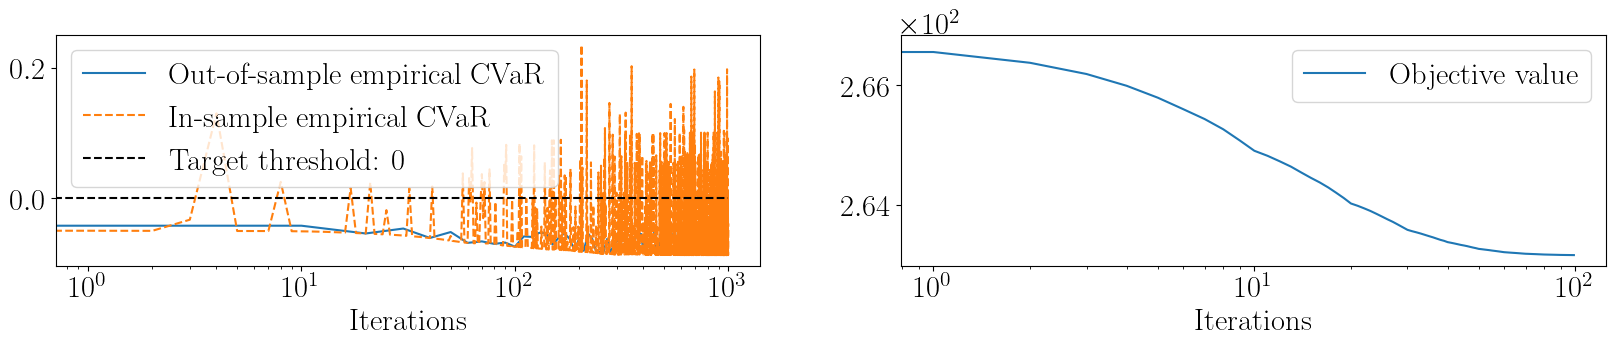

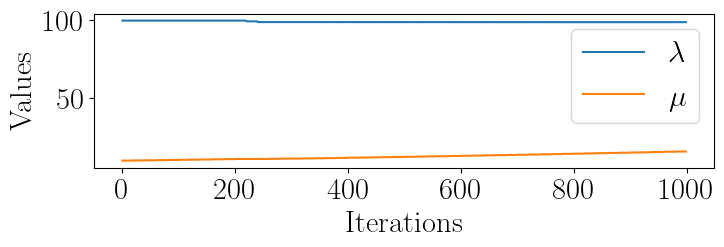

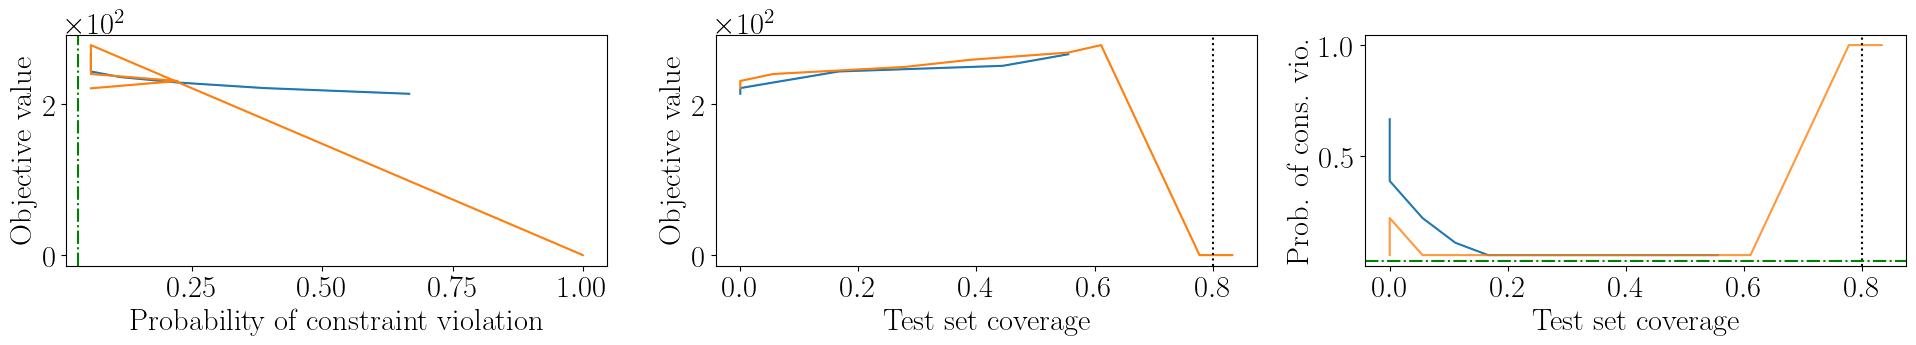

In [20]:
prob_lropt, thevarslropt, theparamslropt, _ = box_robust_dcopf_problem_param_l_max(mu_init, sigma_init, d_dat, w_dat, allow_slack=False, quadratic_cost=True, train=True, traindat=train, p=2, MRO=True, K=5, initeps=0.1)

init_aval = np.diag(np.array(sigma_init))
init_bval = mu_init

init_aval = np.eye(2)
init_bval = np.zeros(2)
# np.random.seed(0)
# init_aval = 0.5*np.random.rand(2,2)+np.eye(2)
# init_bval = -init_aval@mu_init

result8 = prob_lropt.train(init_eps = 1, lr = 0.000001,num_iter=1000, optimizer = "SGD", seed = SEED+1, init_A =1.3*init_aval, init_b = init_bval, init_lam = 100, init_mu = 10, mu_multiplier=1.01, init_alpha = -0.0, test_percentage = TEST_PERC, save_history = False, lr_step_size = 100, lr_gamma = 0.5, position = False, random_init = False, num_random_init=5, parallel = False, kappa=0.05, eta=0.3)

result_reshape8 = prob_lropt.grid(epslst = np.linspace(0.01,2, 10), init_A = result8.A, init_b = result8.b, seed = SEED, init_alpha = 0., test_percentage = 
TEST_PERC)
dfgrid28 = result_reshape8.df

plot_iters(result8.df, result8.df_test,"energy", logscale = True, steps = 1000)

plt.figure(figsize=(8,2))
plt.plot(np.arange(result8.df.shape[0]),np.hstack(result8.df['lam_list']), label = r"$\lambda$")
plt.plot(np.arange(result8.df.shape[0]),result8.df['mu'], label = r"$\mu$")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Values")
# plt.yscale("log")

plot_coverage_all(dfgrid,dfgrid28,None, "energy",ind_1=(0,8),ind_2=(0,9), logscale = False)

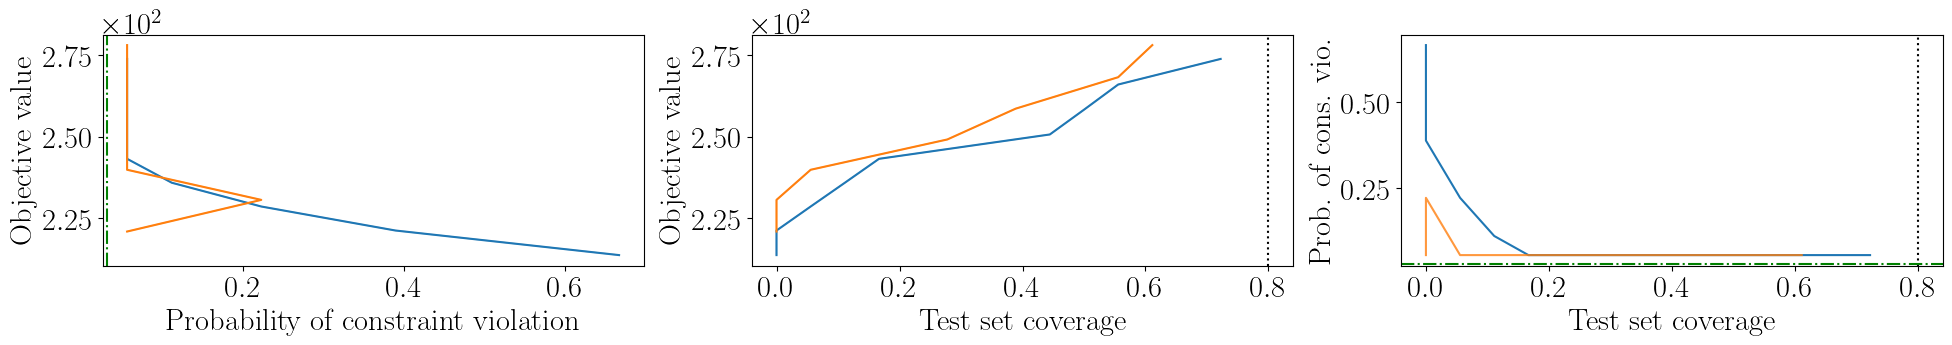

In [25]:
plot_coverage_all(dfgrid,dfgrid28,None, "energy",ind_1=(0,9),ind_2=(0,7), logscale = False)

In [ ]:
prob_lropt, thevarslropt, theparamslropt, _ = box_robust_dcopf_problem_param_l(mu_init, sigma_init, d_dat[0], w_dat[0], allow_slack=False, quadratic_cost=True,inita=result.A, initb=result.b, initeps=1)
prob_lropt.solve()
prob_lropt2, thevarslropt, theparamslropt, _ = box_robust_dcopf_problem_param_l(mu_init, sigma_init, d_dat[0], w_dat[0], allow_slack=False, quadratic_cost=True,inita=init_aval, initb=init_bval, initeps=1 )
prob_lropt2.solve()
print(prob_lropt.value, prob_lropt2.value)


/Users/irina.wang/anaconda3/envs/lropt_s/lib/python3.11/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/robust_problem.py:550: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


268.1445664094267 194.73912471755284


In [19]:
def plot_coverage_all(df_standard,df_reshape,dfs,title,ind_1 = (0,100), ind_2 = (0,100), logscale = True, legend = False, zoom = False):
    plt.rcParams.update({
    "text.usetex":True,

    "font.size":22,
    "font.family": "serif"
})
    beg1,end1 = ind_1
    beg2,end2 = ind_2

    fig, (ax, ax1,ax2) = plt.subplots(1, 3, figsize=(23, 3))
    
    ax.plot(np.mean(np.vstack(df_standard['Probability_violations_test']),axis = 1)[beg1:end1], df_standard['Test_val'][beg1:end1], color="tab:blue", label=r"Mean-Var set", marker = 'o')
    ax.fill(np.append(np.mean(np.vstack(df_standard['Probability_violations_test']),axis = 1)[beg1:end1],np.mean(np.vstack(df_standard['Probability_violations_test']),axis = 1)[beg1:end1][::-1]), np.append(df_standard['Lower_test'][beg1:end1],df_standard['Upper_test'][beg1:end1][::-1]), color="tab:blue", alpha=0.2)

    ax.plot(np.mean(np.vstack(df_reshape['Probability_violations_test']),axis = 1)[beg2:end2], df_reshape['Test_val'][beg2:end2], color="tab:orange", label=r"Reshaped set", marker = 'o')
    ax.fill(np.append(np.mean(np.vstack(df_reshape['Probability_violations_test']),axis = 1)[beg2:end2],np.mean(np.vstack(df_reshape['Probability_violations_test']),axis = 1)[beg2:end2][::-1]), np.append(df_reshape['Lower_test'][beg2:end2],df_reshape['Upper_test'][beg2:end2][::-1]), color="tab:orange", alpha=0.2)
    ax.set_xlabel("Probability of constraint violation")
    ax.axvline(x = 0.03, color = "green", linestyle = "-.",label = r"$\eta = 0.03$")
    # ax.scatter(0.03,y = np.mean([-0.26913068, -0.26968575, -0.26027287, -0.05857202, -0.15843752]), color = "red")
    # ax.axhline(y = np.mean([-0.26913068, -0.26968575, -0.26027287, -0.05857202, -0.15843752]), color = "red", linestyle = "-.",label = r"$MRO = 0.03$")
    
    ax.set_ylabel("Objective value")
    # ax.set_yticks(ticks = [-2e1,0,2e1])
    # ax.set_yticks(ticks = [-1,0,1])
    ax.ticklabel_format(style="sci",axis='y',scilimits = (0,0), useMathText=True)
    # ax.legend()

    ax1.plot(np.mean(np.vstack(df_standard['Coverage_test']),axis = 1)[beg1:end1], np.mean(np.vstack(df_standard['Test_val']),axis = 1)[beg1:end1], color="tab:blue", label=r"Mean-Var set", marker = 'o')
    ax1.fill(np.append(np.quantile(np.vstack(df_standard['Coverage_test']),0.1,axis = 1)[beg1:end1],np.quantile(np.vstack(df_standard['Coverage_test']),0.9,axis = 1)[beg1:end1][::-1]), np.append(np.quantile(np.vstack(df_standard['Test_val']),0.1,axis = 1)[beg1:end1],np.quantile(np.vstack(df_standard['Test_val']),0.90,axis = 1)[beg1:end1][::-1]), color="tab:blue", alpha=0.2)

    ax1.plot(np.mean(np.vstack(df_reshape['Coverage_test']),axis = 1)[beg2:end2],np.mean(np.vstack(df_reshape['Test_val']),axis = 1)[beg2:end2], color = "tab:orange",label=r"Decision-Focused set", marker = 'o')
    ax1.fill(np.append(np.quantile(np.vstack(df_reshape['Coverage_test']),0.1,axis = 1)[beg2:end2],np.quantile(np.vstack(df_reshape['Coverage_test']),0.9,axis = 1)[beg2:end2][::-1]), np.append(np.quantile(np.vstack(df_reshape['Test_val']),0.1,axis = 1)[beg2:end2],np.quantile(np.vstack(df_reshape['Test_val']),0.90,axis = 1)[beg2:end2][::-1]), color="tab:orange", alpha=0.2)
    ax1.ticklabel_format(style="sci",axis='y',scilimits = (0,0), useMathText=True)
    ax1.axvline(x = 0.8, color = "black", linestyle = ":",label = "0.8 Coverage")

    if logscale:
        ax1.set_xscale("log")
    # ax1.set_yticks(ticks = [-1,0,1])

    ax1.set_xlabel("Test set coverage")
    ax1.set_ylabel("Objective value")
    # ax1.legend()

    ax2.plot(df_standard['Coverage_test'][beg1:end1], np.mean(np.vstack(df_standard['Probability_violations_test']),axis = 1)[beg1:end1], color="tab:blue", label=r"Mean-Var set", marker = 'o')

    ax2.plot(df_reshape['Coverage_test'][beg2:end2], np.mean(np.vstack(df_reshape['Probability_violations_test']),axis = 1)[beg2:end2], color="tab:orange", label=r"Reshaped set",alpha = 0.8, marker = 'o')
    
    # ax2.plot(np.arange(100)/100, 1 - np.arange(100)/100, color = "red")
    # ax2.set_ylim([-0.05,0.25])
    ax2.axvline(x = 0.8, color = "black",linestyle = ":", label = "0.8 Coverage")
    ax2.axhline(y = 0.03, color = "green",linestyle = "-.", label = r"$\hat{\eta} = 0.03$")
    ax2.set_ylabel("Prob. of cons. vio.")
    ax2.set_xlabel("Test set coverage")
    if logscale:
        ax2.set_xscale("log")
    # ax2.ticklabel_format(style="sci",axis='y',scilimits = (0,0), useMathText=True)
    # ax2.legend()
    if legend:
        ax2.legend(bbox_to_anchor=(-1.8, -0.6, 0, 0), loc="lower left",
                 borderaxespad=0, ncol=4, fontsize = 24)
    # lines_labels = [ax.get_legend_handles_labels()]
    # lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    # fig.legend(lines, labels,loc='upper center', ncol=2,bbox_to_anchor=(0.5, 1.2))
    plt.subplots_adjust(left=0.1)
    plt.savefig(title+"_curves.pdf",bbox_inches='tight')
    # plt.show()

## Cost-based loss

### Loss function

In [17]:
# use relu to discard negative values
nonneg = torch.nn.ReLU(inplace=False)

def expected_cost(var_values, hist_data_tch, gamma=0):
    
    # some settings
    A_base = 10
    slack_base = 10
    obj_base = basemva/10
    
    p = var_values[0]
    rp = var_values[1]
    rm = var_values[2]
    A = var_values[3]
    fRAMp = var_values[4]
    fRAMm = var_values[5]
    if len(var_values) == 8:
        slack = var_values[-1]
    else:
        slack = torch.tensor(0)
    varlist = [p, rp, rm, A, fRAMp, fRAMm, slack]
    x = torch.hstack([v.flatten() for v in varlist])
        
    # expected first stage cost
    opf_cost = (torch.dot(p, cE_tch) + torch.dot(rp + rm, cR_tch)) 
    opf_cost += torch.sum(slack) * obj_base * 1e3

    # expected reserve violation cost
    reaction_gen = torch.matmul(A/A_base, hist_data_tch.T)
    expected_rp_viol_cost = torch.sum(nonneg(-reaction_gen.T - rp[None, :]).mean(axis=0) * cM_tch)
    expected_rm_viol_cost = torch.sum(nonneg(reaction_gen.T - rm[None, :]).mean(axis=0) * cM_tch)
    reaction_branch = torch.matmul(torch.matmul(ptdf_tch,(wind2bus_tch - torch.matmul(gen2bus_tch, A/A_base))), hist_data_tch.T)
    expected_framp_viol_cost = torch.sum(nonneg(reaction_branch.T - fRAMp[None, :]).mean(axis=0) * cM_tch)
    expected_framm_viol_cost = torch.sum(nonneg(-reaction_branch.T - fRAMm[None, :]).mean(axis=0) * cM_tch)
    
    regularization = gamma*torch.sum(torch.square(x))
    
    return opf_cost + expected_rp_viol_cost + expected_rm_viol_cost + expected_framp_viol_cost + expected_framm_viol_cost + regularization

### Single

Epoch 99: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s, loss=179]


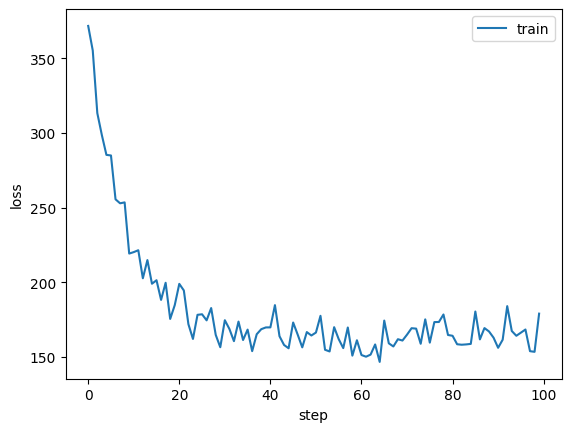

In [18]:
# some additonal settings
LR = 5e-6
LMOM = 0.3
GAMMA = 0.
cM = 2000
BATCHSIZE = 20

# reset randomness
np.random.seed(seed=SEED)

# prepare parameters 
cE_tch = torch.tensor(cE, dtype=DTYPE)
cR_tch = torch.tensor(cR, dtype=DTYPE)
cM_tch = torch.tensor(cM, dtype=DTYPE)
ptdf_tch = torch.tensor(ptdf, dtype=DTYPE)
gen2bus_tch = torch.tensor(gen2bus, dtype=DTYPE)
wind2bus_tch = torch.tensor(wind2bus, dtype=DTYPE)
zero_tch = torch.tensor(0, dtype=DTYPE)

# set up the layer
inner, vs, params, consts = box_robust_dcopf_problem_param(mu_init, sigma_init, d, w, gamma=GAMMA, allow_slack=True, quadratic_cost=False)
inner_cvxpylayer = CvxpyLayer(inner, parameters=inner.parameters(), variables=inner.variables())

# set up base model for comparison
base_prob, _, _, _ = box_robust_dcopf_problem_param(mu_base_perc, sigma_base_perc, d, w, gamma=GAMMA, allow_slack=True, quadratic_cost=False)

# set up the prescriptor
sigma_tch = torch.tensor(sigma_init, dtype=DTYPE, requires_grad=True)
mu_tch = torch.tensor(mu_init, dtype=DTYPE, requires_grad=True)

# set up SGD 
opt = torch.optim.SGD([mu_tch, sigma_tch], lr=LR, momentum=LMOM) 
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=5)

#train
loss_during_training = []
training_data_df = pd.DataFrame()
with trange(MAX_EPOCH) as ep_looper:
    for epoch in ep_looper:
        ep_looper.set_description(f'Epoch {epoch}')
        
        # reset loss
        loss = torch.tensor(0., dtype=DTYPE)
        
        for batch in range(BATCHSIZE):
            # create net demand scenario 
            d_scenario_np = np.random.uniform(*d_range, B) * d
            d_scenario = torch.tensor(d_scenario_np, dtype=DTYPE)
            w_scenario_np = np.random.uniform(*w_range, D) * w
            w_scenario = torch.tensor(w_scenario_np, dtype=DTYPE)
            scenario_vector = torch.cat((d_scenario, w_scenario))
        
            # compute current inner solution
            opf_params = [w_scenario, d_scenario, mu_tch, sigma_tch]
            var_values = inner_cvxpylayer(*opf_params,  solver_args={'solve_method': "ECOS"})
            
            # calculate loss
            temploss = expected_cost(var_values, train_data, gamma=GAMMA)
            loss = loss + temploss/BATCHSIZE
            
        # backpropagate
        loss.backward()

        # step the SGD
        opt.step()
        opt.zero_grad()
        scheduler.step(loss)
        
        # some analysis and reporting
        current_results = pd.Series({
            "epoch": epoch,
            "loss": loss.item(),
            "mu": mu_tch.detach().numpy(),
            "sigma": sigma_tch.detach().numpy(),
        })
        training_data_df = pd.concat([training_data_df, current_results.to_frame().T], ignore_index=True)
        loss_during_training.append(loss.item())
        ep_looper.set_postfix(loss=loss.item())
        
results_without_prescription = training_data_df.copy()
            
# some final reporting    
fig, ax = plt.subplots(1,1)
ax.plot(loss_during_training, label='train')
ax.set_ylabel('loss')
ax.set_xlabel('step')
ax.legend()

### P-All

In [15]:
# some additonal settings
LR = 1e-6
LMOM = 0.3
GAMMA = 0.1
cM = 2000

# reset randomness
np.random.seed(seed=SEED)

# prepare parameters 
cE_tch = torch.tensor(cE, dtype=DTYPE)
cR_tch = torch.tensor(cR, dtype=DTYPE)
cM_tch = torch.tensor(cM, dtype=DTYPE)
ptdf_tch = torch.tensor(ptdf, dtype=DTYPE)
gen2bus_tch = torch.tensor(gen2bus, dtype=DTYPE)
wind2bus_tch = torch.tensor(wind2bus, dtype=DTYPE)
zero_tch = torch.tensor(0, dtype=DTYPE)

# set up the layer
inner, vs, params, consts = box_robust_dcopf_problem_param(mu_init, sigma_init, d, w, gamma=GAMMA, allow_slack=True, quadratic_cost=False)
inner_cvxpylayer = CvxpyLayer(inner, parameters=inner.parameters(), variables=inner.variables())

# set up base model for comparison
base_prob, _, _, _ = box_robust_dcopf_problem_param(mu_base_perc, sigma_base_perc, d, w, gamma=GAMMA, allow_slack=True, quadratic_cost=False)

# set up the prescriptor
sigma_prescriptor = torch.nn.Linear(B+D, D)
sigma_prescriptor.weight.data = torch.zeros((D, B+D))
sigma_prescriptor.bias.data = torch.tensor(sigma_init, dtype=DTYPE)
mu_prescriptor = torch.nn.Linear(B+D, D)
mu_prescriptor.weight.data = torch.zeros((D, B+D))
mu_prescriptor.bias.data = torch.tensor(mu_init, dtype=DTYPE)

# set up SGD 
parameters = list(mu_prescriptor.parameters()) + list(sigma_prescriptor.parameters())
opt = torch.optim.SGD(parameters, lr=LR, momentum=LMOM) 
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=5)

#train
loss_during_training = []
training_data_df = pd.DataFrame()
with trange(MAX_EPOCH) as ep_looper:
    for epoch in ep_looper:
        ep_looper.set_description(f'Epoch {epoch}')
        
        # reset loss
        loss = torch.tensor(0., dtype=DTYPE)
        oosloss = torch.tensor(0., dtype=DTYPE)
        baseloss = torch.tensor(0., dtype=DTYPE)
    
        for batch in range(BATCHSIZE):
            # create net demand scenario 
            d_scenario_np = np.random.uniform(*d_range, B) * d
            d_scenario = torch.tensor(d_scenario_np, dtype=DTYPE)
            w_scenario_np = np.random.uniform(*w_range, D) * w
            w_scenario = torch.tensor(w_scenario_np, dtype=DTYPE)
            scenario_vector = torch.cat((d_scenario, w_scenario))
            
            # prescribe the the set size
            mu = mu_prescriptor(scenario_vector.float())
            sigma = sigma_prescriptor(scenario_vector.float())
        
            # compute current inner solution
            opf_params = [w_scenario, d_scenario, mu, sigma]
            var_values = inner_cvxpylayer(*opf_params,  solver_args={'solve_method': "ECOS"})
            
            # calculate loss
            temploss = expected_cost(var_values, train_data, gamma=GAMMA)
            loss = loss + temploss/BATCHSIZE
              
        # backpropagate
        loss.backward()

        # step the SGD
        opt.step()
        opt.zero_grad()
        scheduler.step(loss)
        
        # some analysis and reporting
        current_results = pd.Series({
            "epoch": epoch,
            "loss": loss.item(),
            "mu_pres_weight": mu_prescriptor.weight.data.detach(),
            "mu_pres_bias": mu_prescriptor.bias.data.detach(),
            "sigma_pres_weight": sigma_prescriptor.weight.data.detach(),
            "sigma_pres_bias": sigma_prescriptor.bias.data.detach(),
        })
        training_data_df = pd.concat([training_data_df, current_results.to_frame().T], ignore_index=True)
        loss_during_training.append(loss.item())
        ep_looper.set_postfix(loss=loss.item())

results_with_prescription = training_data_df.copy()
            
# some final reporting    
fig, ax = plt.subplots(1,1)
ax.plot(loss_during_training, label='train')
ax.set_ylabel('loss')
ax.set_xlabel('step')
ax.legend()

Epoch 0:   0%|          | 0/100 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 must have the same dtype, but got Double and Float

In [13]:
DTYPE = torch.float32

# now lets try with prescriptor model
# cM = 1000
cM = 2000

MAX_EPOCH = 100
BATCHSIZE = 20
REL_DATA_BATCH = 0.2
LR = 1e-6
LMOM = 0.3
GAMMA = 0.1

# reset randomness
np.random.seed(seed=SEED)

# some other settings
d_range = [0.5, 1.1]
w_range = [0.5, 1.1]

# exogenous parameters 
# TODO all global and weird now
cE_tch = torch.tensor(cE, dtype=DTYPE)
cR_tch = torch.tensor(cR, dtype=DTYPE)
cM_tch = torch.tensor(cM, dtype=DTYPE)
ptdf_tch = torch.tensor(ptdf, dtype=DTYPE)
gen2bus_tch = torch.tensor(gen2bus, dtype=DTYPE)
wind2bus_tch = torch.tensor(wind2bus, dtype=DTYPE)
zero_tch = torch.tensor(0, dtype=DTYPE)

# set up the layer
inner, vs, params, consts = box_robust_dcopf_problem_param(mu_init, sigma_init, d, w, gamma=GAMMA, allow_slack=True, quadratic_cost=False)
inner_cvxpylayer = CvxpyLayer(inner, parameters=inner.parameters(), variables=inner.variables())

# set up base model for comparison
base_prob, _, _, _ = box_robust_dcopf_problem_param(mu_base_perc, sigma_base_perc, d, w, gamma=GAMMA, allow_slack=True, quadratic_cost=False)

# set up the prescriptor
sigma_prescriptor = torch.nn.Linear(B+D, D)
sigma_prescriptor.weight.data = torch.zeros((D, B+D))
sigma_prescriptor.bias.data = torch.tensor(sigma_init, dtype=DTYPE)
mu_prescriptor = torch.nn.Linear(B+D, D)
mu_prescriptor.weight.data = torch.zeros((D, B+D))
mu_prescriptor.bias.data = torch.tensor(mu_init, dtype=DTYPE)

# set up SGD 
parameters = list(mu_prescriptor.parameters()) + list(sigma_prescriptor.parameters())
opt = torch.optim.SGD(parameters, lr=LR, momentum=LMOM) 
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=5)

#train
loss_during_training = []
# oosloss_during_training = []
# baseloss_during_training = []
training_data_df = pd.DataFrame()
# for epoch in trange(MAX_EPOCH, desc="Training progress", unit="epoch"):
with trange(MAX_EPOCH) as ep_looper:
    for epoch in ep_looper:
        ep_looper.set_description(f'Epoch {epoch}')
        
        # reset loss
        loss = torch.tensor(0., dtype=DTYPE)
        oosloss = torch.tensor(0., dtype=DTYPE)
        baseloss = torch.tensor(0., dtype=DTYPE)
    
         # create net demand scenario 
        d_scenario_np = np.random.uniform(*d_range, B) * d
        d_scenario = torch.tensor(d_scenario_np, dtype=DTYPE)
        w_scenario_np = np.random.uniform(*w_range, D) * w
        w_scenario = torch.tensor(w_scenario_np, dtype=DTYPE)
        scenario_vector = torch.cat((d_scenario, w_scenario))

        # prescribe the the set size
        mu = mu_prescriptor(scenario_vector.float())
        sigma = sigma_prescriptor(scenario_vector.float())

        for batch in range(BATCHSIZE):
            
            batch_data_ids = np.random.randint(0, train.shape[0], int(train_data.shape[0]*REL_DATA_BATCH))   
           
            # compute current inner solution
            opf_params = [w_scenario, d_scenario, mu, sigma]
            var_values = inner_cvxpylayer(*opf_params,  solver_args={'solve_method': "ECOS"})
            
            # calculate loss
            temploss = expected_cost(var_values, train_data[batch_data_ids], gamma=GAMMA)
            loss = loss + temploss/BATCHSIZE
            
#             # calculate oos loss
#             tempoosloss = expected_cost(var_values, test_data, gamma=GAMMA)
#             oosloss = oosloss + tempoosloss/BATCHSIZE
            
#             # calculate base loss
#             base_prob.parameters()[0].value = w_scenario_np
#             base_prob.parameters()[1].value = d_scenario_np
#             base_prob.solve(solver='ECOS', warm_start=True)
#             base_var_values = [torch.tensor(v.value, dtype=DTYPE) for v in base_prob.variables()]
#             tempbaseloss = expected_cost(base_var_values, test_data, gamma=GAMMA)
#             baseloss = baseloss + tempbaseloss/BATCHSIZE
              
        # backpropagate
        loss.backward()

        # step the SGD
        opt.step()
        opt.zero_grad()
        scheduler.step(loss)
        
        # some analysis and reporting
        current_results = pd.Series({
            "epoch": epoch,
            "loss": loss.item(),
            "mu_pres_weight": mu_prescriptor.weight.data.detach(),
            "mu_pres_bias": mu_prescriptor.bias.data.detach(),
            "sigma_pres_weight": sigma_prescriptor.weight.data.detach(),
            "sigma_pres_bias": sigma_prescriptor.bias.data.detach(),
        })
        training_data_df = pd.concat([training_data_df, current_results.to_frame().T], ignore_index=True)
        loss_during_training.append(loss.item())
        # oosloss_during_training.append(oosloss.item())
        # baseloss_during_training.append(baseloss.item())
        ep_looper.set_postfix(loss=loss.item())
        # if epoch % 10 == 9:
            # print(f'Epoch: {epoch} | Loss: {loss_during_training[-1]} | mu: {mu_during_training[-1]} | sigma: {sigma_during_training[-1]}')
results_with_prescription_outer_sample = training_data_df.copy()
            
# some final reporting    
fig, ax = plt.subplots(1,1)
ax.plot(loss_during_training, label='train')
# ax.plot(oosloss_during_training, label='test')
# ax.plot(baseloss_during_training, label='base')
ax.set_ylabel('loss')
ax.set_xlabel('step')
ax.legend()

Epoch 0:   0%|          | 0/100 [00:00<?, ?it/s]


RuntimeError: expected m1 and m2 to have the same dtype, but got: float != double

### P-Cond

Epoch 99: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s, loss=139]


Text(0.5, 0, 'step')

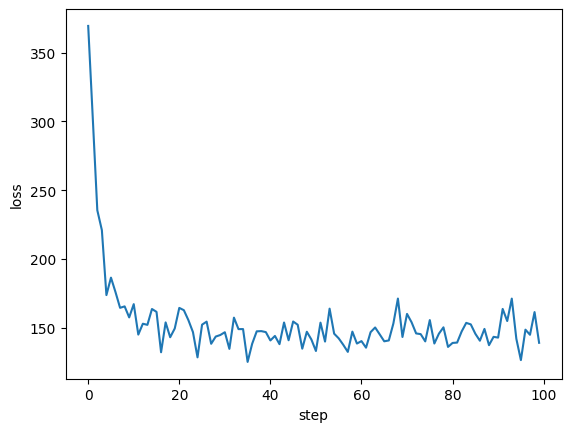

In [14]:
# some additonal settings
LR = 1e-6
LMOM = 0.3
GAMMA = 0.
cM = 2000

# reset randomness
np.random.seed(seed=SEED)

# prepare parameters 
cE_tch = torch.tensor(cE, dtype=DTYPE)
cR_tch = torch.tensor(cR, dtype=DTYPE)
cM_tch = torch.tensor(cM, dtype=DTYPE)
ptdf_tch = torch.tensor(ptdf, dtype=DTYPE)
gen2bus_tch = torch.tensor(gen2bus, dtype=DTYPE)
wind2bus_tch = torch.tensor(wind2bus, dtype=DTYPE)
zero_tch = torch.tensor(0, dtype=DTYPE)

# set up the layer
inner, vs, params, consts = box_robust_dcopf_problem_param(mu_init, sigma_init, d, w, gamma=GAMMA, allow_slack=True, quadratic_cost=False)
inner_cvxpylayer = CvxpyLayer(inner, parameters=inner.parameters(), variables=inner.variables())

# set up the prescriptor
sigma_prescriptor = torch.nn.Linear(B+D, D)
sigma_prescriptor.weight.data = torch.zeros((D, B+D))
sigma_prescriptor.bias.data = torch.tensor(sigma_init, dtype=DTYPE)
mu_prescriptor = torch.nn.Linear(B+D, D)
mu_prescriptor.weight.data = torch.zeros((D, B+D))
mu_prescriptor.bias.data = torch.tensor(mu_init, dtype=DTYPE)

# set up SGD 
parameters = list(mu_prescriptor.parameters()) + list(sigma_prescriptor.parameters())
opt = torch.optim.SGD(parameters, lr=LR, momentum=LMOM) 
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=5)

#train
loss_during_training = []
training_data_df = pd.DataFrame()
with trange(MAX_EPOCH) as ep_looper:
    for epoch in ep_looper:
        ep_looper.set_description(f'Epoch {epoch}')
        
        # reset loss
        loss = torch.tensor(0., dtype=DTYPE)
        
        for batch in range(BATCHSIZE):
            # create net demand scenario 
            d_scenario_np = np.random.uniform(*d_range, B) * d
            d_scenario = torch.tensor(d_scenario_np, dtype=DTYPE)
            w_scenario_np = np.random.uniform(*w_range, D) * w
            w_scenario = torch.tensor(w_scenario_np, dtype=DTYPE)
            scenario_vector = torch.cat((d_scenario, w_scenario))
            
            # prescribe the the set size
            mu = mu_prescriptor(scenario_vector.float())
            sigma = sigma_prescriptor(scenario_vector.float())
        
            # compute current inner solution
            opf_params = [w_scenario, d_scenario, mu, sigma]
            var_values = inner_cvxpylayer(*opf_params,  solver_args={'solve_method': "ECOS"})
            
            # create forecast errors based on wind scenario
            cur_data = create_historical_data(w_scenario_np, N=200, corr=0.5)
            cur_data = torch.tensor(cur_data, dtype=DTYPE)
            
            # calculate loss
            temploss = expected_cost(var_values, cur_data, gamma=GAMMA)
            loss = loss + temploss/BATCHSIZE
              
        # backpropagate
        loss.backward()

        # step the SGD
        opt.step()
        opt.zero_grad()
        scheduler.step(loss)
        
        # some analysis and reporting
        current_results = pd.Series({
            "epoch": epoch,
            "loss": loss.item(),
            "mu_pres_weight": mu_prescriptor.weight.data.detach(),
            "mu_pres_bias": mu_prescriptor.bias.data.detach(),
            "sigma_pres_weight": sigma_prescriptor.weight.data.detach(),
            "sigma_pres_bias": sigma_prescriptor.bias.data.detach(),
        })
        training_data_df = pd.concat([training_data_df, current_results.to_frame().T], ignore_index=True)
        loss_during_training.append(loss.item())
        ep_looper.set_postfix(loss=loss.item())

results_with_prescription_and_cond_error = training_data_df.copy()
            
# some final reporting    
fig, ax = plt.subplots(1,1)
ax.plot(loss_during_training)
ax.set_ylabel('loss')
ax.set_xlabel('step')

### P-Bins

Epoch 99: 100%|██████████| 100/100 [00:13<00:00,  7.30it/s, loss=159]


Text(0.5, 0, 'step')

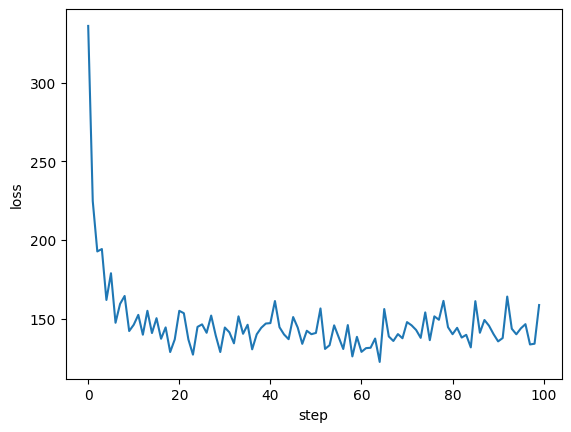

In [16]:
# some additional settings
LR = 1e-6
LMOM = 0.3
GAMMA = 0.
cM = 2000

# reset randomness
np.random.seed(seed=SEED)

# exogenous parameters 
cE_tch = torch.tensor(cE, dtype=DTYPE)
cR_tch = torch.tensor(cR, dtype=DTYPE)
cM_tch = torch.tensor(cM, dtype=DTYPE)
ptdf_tch = torch.tensor(ptdf, dtype=DTYPE)
gen2bus_tch = torch.tensor(gen2bus, dtype=DTYPE)
wind2bus_tch = torch.tensor(wind2bus, dtype=DTYPE)
zero_tch = torch.tensor(0, dtype=DTYPE)

# set up the layer
inner, vs, params, consts = box_robust_dcopf_problem_param(mu_init, sigma_init, d, w, gamma=GAMMA, allow_slack=True, quadratic_cost=False)
inner_cvxpylayer = CvxpyLayer(inner, parameters=inner.parameters(), variables=inner.variables())

# set up the prescriptor
sigma_prescriptor = torch.nn.Linear(B+D, D)
sigma_prescriptor.weight.data = torch.zeros((D, B+D))
sigma_prescriptor.bias.data = torch.tensor(sigma_init, dtype=DTYPE)
mu_prescriptor = torch.nn.Linear(B+D, D)
mu_prescriptor.weight.data = torch.zeros((D, B+D))
mu_prescriptor.bias.data = torch.tensor(mu_init, dtype=DTYPE)

# set up SGD 
parameters = list(mu_prescriptor.parameters()) + list(sigma_prescriptor.parameters())
opt = torch.optim.SGD(parameters, lr=LR, momentum=LMOM) 
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=5)

#train
loss_during_training = []
training_data_df = pd.DataFrame()
with trange(MAX_EPOCH) as ep_looper:
    for epoch in ep_looper:
        ep_looper.set_description(f'Epoch {epoch}')
        
        # reset loss
        loss = torch.tensor(0., dtype=DTYPE)
        
        for batch in range(BATCHSIZE):
            # create net demand scenario 
            d_scenario_np = np.random.uniform(*d_range, B) * d
            d_scenario = torch.tensor(d_scenario_np, dtype=DTYPE)
            w_scenario_np = np.random.uniform(*w_range, D) * w
            w_scenario = torch.tensor(w_scenario_np, dtype=DTYPE)
            scenario_vector = torch.cat((d_scenario, w_scenario))
            
            # prescribe the the set size
            mu = mu_prescriptor(scenario_vector.float())
            sigma = sigma_prescriptor(scenario_vector.float())
        
            # compute current inner solution
            opf_params = [w_scenario, d_scenario, mu, sigma]
            var_values = inner_cvxpylayer(*opf_params,  solver_args={'solve_method': "ECOS"})
            
            # select forecast errors from wind scenario
            cur_bins = [np.digitize(w_scenario_np[i], bins[i]) for i in range(D)]
            cur_errors = [train_errors_in_bins[i][cur_bins[i]] for i in range(D)]
            min_len = min((len(a) for a in cur_errors))
            cur_errors = [a[:min_len] for a in cur_errors]
            cur_data = np.column_stack(cur_errors)
            cur_data = torch.tensor(cur_data, dtype=DTYPE)
            
            # calculate loss
            temploss = expected_cost(var_values, cur_data, gamma=GAMMA)
            loss = loss + temploss/BATCHSIZE
              
        # backpropagate
        loss.backward()

        # step the SGD
        opt.step()
        opt.zero_grad()
        scheduler.step(loss)
        
        # some analysis and reporting
        current_results = pd.Series({
            "epoch": epoch,
            "loss": loss.item(),
            "mu_pres_weight": mu_prescriptor.weight.data.detach(),
            "mu_pres_bias": mu_prescriptor.bias.data.detach(),
            "sigma_pres_weight": sigma_prescriptor.weight.data.detach(),
            "sigma_pres_bias": sigma_prescriptor.bias.data.detach(),
        })
        training_data_df = pd.concat([training_data_df, current_results.to_frame().T], ignore_index=True)
        loss_during_training.append(loss.item())
        ep_looper.set_postfix(loss=loss.item())

results_with_prescription_and_imp_cond_error = training_data_df.copy()
            
# some final reporting    
fig, ax = plt.subplots(1,1)
ax.plot(loss_during_training)
ax.set_ylabel('loss')
ax.set_xlabel('step')

### OOS testing

In [17]:
# in oos gamma is always zero
GAMMA = 0.
cM = 2000

# get final training
def get_prescriptors(training_results):
    final_training_epoch = training_results.iloc[-1]
    sigma_prescriptor = torch.nn.Linear(B+D, D)
    sigma_prescriptor.weight.data = final_training_epoch.sigma_pres_weight
    sigma_prescriptor.bias.data = final_training_epoch.sigma_pres_bias
    mu_prescriptor = torch.nn.Linear(B+D, D)
    mu_prescriptor.weight.data = final_training_epoch.mu_pres_weight
    mu_prescriptor.bias.data = final_training_epoch.mu_pres_bias
    return mu_prescriptor, sigma_prescriptor

# create model
prob, thevars, theparams, _ = box_robust_dcopf_problem_param(mu_init, sigma_init, d, w, gamma=GAMMA, allow_slack=True, quadratic_cost=False)

pu_scale = 100
N_OOS = 500
oos_loss_base = []
oos_loss_full = []
oos_loss_single = []
oos_loss_presc = []
oos_loss_presc_cond = []
oos_loss_presc_imp_cond = []
for oos in trange(N_OOS):

    # create a scenario
    d_scenario_np = np.random.uniform(*d_range, B) * d
    w_scenario_np = np.random.uniform(*w_range, D) * w
    d_scenario = torch.tensor(d_scenario_np, dtype=DTYPE)
    w_scenario = torch.tensor(w_scenario_np, dtype=DTYPE)
    scenario_vector = torch.cat((d_scenario, w_scenario))
    # create a single error occurence
    cur_error = create_historical_data(w_scenario_np, N=12, corr=CORR)
    cur_data = torch.tensor(cur_error, dtype=DTYPE)

    ## base model
    theparams[0].value = d_scenario_np
    theparams[1].value = w_scenario_np
    theparams[2].value = mu_base_perc
    theparams[3].value = sigma_base_perc
    prob.solve(solver='ECOS', warm_start=True)
    var_values = [torch.tensor(v.value, dtype=DTYPE) for v in thevars]
    # compute loss for the prescribed model
    loss_base = expected_cost(var_values, cur_data, gamma=GAMMA)
    oos_loss_base.append(loss_base.item() * pu_scale)
    
    ## full robust
    mine = np.min(train, axis=0)
    maxe = np.min(train, axis=0)
    theparams[2].value = (maxe + mine) / 2
    theparams[3].value = mu_init + ((maxe - mine) / 2)
    prob.solve(solver='ECOS', warm_start=True)
    var_values = [torch.tensor(v.value, dtype=DTYPE) for v in thevars]
    # compute loss for the prescribed model
    loss_full = expected_cost(var_values, cur_data, gamma=GAMMA)
    oos_loss_full.append(loss_full.item() * pu_scale)
    
    ## one size fits all
    final_epoch = results_without_prescription.iloc[-1]
    theparams[2].value = final_epoch.mu
    theparams[3].value = final_epoch.sigma
    prob.solve(solver='ECOS', warm_start=True)
    var_values = [torch.tensor(v.value, dtype=DTYPE) for v in thevars]
    # compute loss for the prescribed model
    loss_single = expected_cost(var_values, cur_data, gamma=GAMMA)
    oos_loss_single.append(loss_single.item() * pu_scale)
    
    ## prescribed model
    # parametrize prescribed model
    mu_presc, sigma_presc = get_prescriptors(results_with_prescription)
    # mu_presc, sigma_presc = get_prescriptors(results_with_prescription_outer_sample)
    theparams[2].value = mu_presc(scenario_vector).detach().numpy()
    theparams[3].value = sigma_presc(scenario_vector).detach().numpy()
    prob.solve(solver='ECOS', warm_start=True)
    var_values = [torch.tensor(v.value, dtype=DTYPE) for v in thevars]
    # compute loss for the prescribed model
    loss_presc = expected_cost(var_values, cur_data, gamma=GAMMA)
    oos_loss_presc.append(loss_presc.item() * pu_scale)
    
    ## prescribed model with perfect knowledge of conditional distributon
    mu_presc_cond, sigma_presc_cond = get_prescriptors(results_with_prescription_and_cond_error)
    theparams[2].value = mu_presc_cond(scenario_vector).detach().numpy()
    theparams[3].value = sigma_presc_cond(scenario_vector).detach().numpy()
    prob.solve(solver='ECOS', warm_start=True)
    var_values = [torch.tensor(v.value, dtype=DTYPE) for v in thevars]
    # compute loss for the prescribed model
    loss_presc_cond = expected_cost(var_values, cur_data, gamma=GAMMA)
    oos_loss_presc_cond.append(loss_presc_cond.item() * pu_scale)
    
    ## prescribed model with IMperfect knowledge of conditional distributon
    mu_presc_imp_cond, sigma_presc_imp_cond = get_prescriptors(results_with_prescription_and_imp_cond_error)
    theparams[2].value = mu_presc_imp_cond(scenario_vector).detach().numpy()
    theparams[3].value = sigma_presc_imp_cond(scenario_vector).detach().numpy()
    prob.solve(solver='ECOS', warm_start=True)
    var_values = [torch.tensor(v.value, dtype=DTYPE) for v in thevars]
    # compute loss for the prescribed model
    loss_presc_imp_cond = expected_cost(var_values, cur_data, gamma=GAMMA)
    oos_loss_presc_imp_cond.append(loss_presc_imp_cond.item() * pu_scale)

    
for ci,cn in enumerate(['B', 'Full', 'OSFA', 'P', 'PC', 'PIPC']):
    curec = np.mean([oos_loss_base, oos_loss_full, oos_loss_single, oos_loss_presc, oos_loss_presc_cond, oos_loss_presc_imp_cond][ci])
    print(f'Expected cost case {cn}: {curec:.3f}')

  0%|          | 0/500 [00:00<?, ?it/s]


NameError: name 'results_with_prescription' is not defined

## Constraint-based loss

### Loss function

In [ ]:
def cvar_loss(var_values, tau, lam, hist_data_tch, gamma=0., quantile=0.95, target=0., mu=0.):
    
    # some settings
    A_base = 10.
    slack_base = 10.
    obj_base = basemva/10.
    
    p = var_values[0]
    rp = var_values[1]
    rm = var_values[2]
    A = var_values[3]
    fRAMp = var_values[4]
    fRAMm = var_values[5]
    if len(var_values) == 8:
        slack = var_values[-1]
    else:
        slack = torch.tensor(0.)
    varlist = [p, rp, rm, A, fRAMp, fRAMm, slack]
    x = torch.hstack([v.flatten() for v in varlist])
        
    # expected objective (objectice is deterministic in this case)
    enercost = (torch.dot(p, cE_tch) + torch.dot(rp + rm, cR_tch))
    slack_penalty = torch.sum(slack) * obj_base * 1e3
    reg_penalty = gamma*torch.sum(torch.square(x)) # regularization
    opf_cost = enercost + slack_penalty + reg_penalty
    
    # cvar
    reaction_gen = torch.matmul(-A/A_base, hist_data_tch.T)
    g_rp = reaction_gen.T - rp[None, :]
    g_rm = -reaction_gen.T - rm[None, :]
    reaction_branch = torch.matmul(torch.matmul(ptdf_tch,(wind2bus_tch - torch.matmul(gen2bus_tch, A/A_base))), hist_data_tch.T)
    g_framp = reaction_branch.T - fRAMp[None, :]
    g_framm = -reaction_branch.T - fRAMm[None, :]
    g = torch.cat((g_rp, g_rm, g_framp, g_framm), dim=1)
    g_max, _ = torch.max(g, dim=1)
    
    cvar = torch.mean(torch.maximum(g_max - tau, torch.tensor(0.,dtype=DTYPE)))/(1-quantile) + tau
    
    n_violations = sum(g_max > 0.)
    total_loss = opf_cost + lam*(cvar - target) + (mu/2)*(cvar - target)**2.
    
    return total_loss, opf_cost, cvar, n_violations

### Single

In [ ]:
# some additional settings
LR = 1e-5
LMOM = 0.5
GAMMA = 0.1
cM = 2000

CVAR_TARGET = 0.
CVAR_QUANT = 0.99 # target level of security

MU_INIT = 1.
TAU_INIT = 0.
LAM_INIT = 500
LAM_STEP = 0.1

# reset randomness
np.random.seed(seed=SEED)

# prepare parameters 
cE_tch = torch.tensor(cE, dtype=DTYPE)
cR_tch = torch.tensor(cR, dtype=DTYPE)
cM_tch = torch.tensor(cM, dtype=DTYPE)
ptdf_tch = torch.tensor(ptdf, dtype=DTYPE)
gen2bus_tch = torch.tensor(gen2bus, dtype=DTYPE)
wind2bus_tch = torch.tensor(wind2bus, dtype=DTYPE)
zero_tch = torch.tensor(0, dtype=DTYPE)

# set up the layer
inner, vs, params, consts = box_robust_dcopf_problem_param(mu_init, sigma_init, d, w, gamma=GAMMA, allow_slack=True, quadratic_cost=False)
inner_cvxpylayer = CvxpyLayer(inner, parameters=inner.parameters(), variables=inner.variables())

# set up the prescriptor
sigma_tch = torch.tensor(sigma_init, dtype=DTYPE, requires_grad=True)
mu_tch = torch.tensor(mu_init, dtype=DTYPE, requires_grad=True)

# set up auxillary variables
tau_tch = torch.tensor(TAU_INIT, dtype=DTYPE, requires_grad=True)
lam_tch = torch.tensor(LAM_INIT, dtype=DTYPE)

# set up SGD 
parameters = [mu_tch, sigma_tch, tau_tch]
opt = torch.optim.SGD(parameters, lr=LR, momentum=LMOM) 
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=5)

#train
loss_during_training = []
training_data_df = pd.DataFrame()
with trange(MAX_EPOCH) as ep_looper:
    for epoch in ep_looper:
        ep_looper.set_description(f'Epoch {epoch}')
        
        # reset loss
        loss = torch.tensor(0., dtype=DTYPE)
        
        # aux reset
        cvar = torch.tensor(0., dtype=DTYPE)
        opfcost = 0.
        violations = 0.
        
        for batch in range(BATCHSIZE):
            # create net demand scenario 
            d_scenario_np = np.random.uniform(*d_range, B) * d
            d_scenario = torch.tensor(d_scenario_np, dtype=DTYPE)
            w_scenario_np = np.random.uniform(*w_range, D) * w
            w_scenario = torch.tensor(w_scenario_np, dtype=DTYPE)
            scenario_vector = torch.cat((d_scenario, w_scenario))
        
            # compute current inner solution
            opf_params = [w_scenario, d_scenario, mu_tch, sigma_tch]
            var_values = inner_cvxpylayer(*opf_params,  solver_args={'solve_method': "ECOS"})
            
            # calculate loss
            temploss, tempopf, tempcvar, tempviolations = cvar_loss(var_values, tau_tch, lam_tch, train_data, 
                                                            gamma=0., quantile=CVAR_QUANT, target=CVAR_TARGET, mu=1.)
            loss = loss + temploss/BATCHSIZE
            cvar = cvar + tempcvar.detach()/BATCHSIZE
            opfcost = opfcost + tempopf.item()/BATCHSIZE
            violations = violations + tempviolations.item()/BATCHSIZE
          
        # compute empirical violation probability
        violation_prob = violations/train_data.size()[0]
        
        # update lambda
        lam_tch = torch.maximum(lam_tch + LAM_STEP * cvar, torch.tensor(0., dtype=DTYPE)) 

        # backpropagate the lagrangian
        loss.backward()
        
        # some analysis and reporting
        current_results = pd.Series({
            "epoch": epoch,
            "loss": loss.item(),
            "mu": mu_tch.detach().numpy(),
            "sigma": sigma_tch.detach().numpy(),
            "violation_prob": violation_prob,
            "opfcost": opfcost,
            "cvar": cvar.detach().numpy().copy(),
            "tau_grad": tau_tch.grad, 
            "tau": tau_tch.detach().numpy().copy(),
            "lam": lam_tch.detach().numpy().copy(),
        })
        training_data_df = pd.concat([training_data_df, current_results.to_frame().T], ignore_index=True)
        loss_during_training.append(loss.item())
        ep_looper.set_postfix(violation_prob=violation_prob, cvar=cvar.detach().numpy().copy())
        
        # step and reset the SGD
        opt.step()
        opt.zero_grad()
        scheduler.step(loss)
                
results_cvar_without_prescription = training_data_df.copy()
            
# some final reporting    
fig, axs = plt.subplots(3,1)
fig.tight_layout(pad=1.5)
training_viol_prob = training_data_df.violation_prob.to_numpy()
training_cvar = training_data_df.cvar.to_numpy()
training_opfcost = training_data_df.opfcost.to_numpy()
axs[0].plot(training_viol_prob, label='train')
axs[0].set_ylabel('violation probability')
axs[0].set_xlabel('step')
axs[1].plot(training_cvar, label='train')
axs[1].set_ylabel('cvar')
axs[1].set_xlabel('step')
axs[2].plot(training_opfcost, label='train')
axs[2].set_ylabel('opfcost')
axs[2].set_xlabel('step')
;

### P-All

In [ ]:
# some addtional settings
LR = 1e-6
LMOM = 0.
GAMMA = 0.1
cM = 2000

CVAR_TARGET = 0.
CVAR_QUANT = 0.99 # target level of security

MU_INIT = 1.
TAU_INIT = 0.
LAM_INIT = 500
LAM_STEP = 0.1

# reset randomness
np.random.seed(seed=SEED)

# prepare parameters 
cE_tch = torch.tensor(cE, dtype=DTYPE)
cR_tch = torch.tensor(cR, dtype=DTYPE)
cM_tch = torch.tensor(cM, dtype=DTYPE)
ptdf_tch = torch.tensor(ptdf, dtype=DTYPE)
gen2bus_tch = torch.tensor(gen2bus, dtype=DTYPE)
wind2bus_tch = torch.tensor(wind2bus, dtype=DTYPE)
zero_tch = torch.tensor(0, dtype=DTYPE)

# set up the layer
inner, vs, params, consts = box_robust_dcopf_problem_param(mu_init, sigma_init, d, w, gamma=GAMMA, allow_slack=True, quadratic_cost=False)
inner_cvxpylayer = CvxpyLayer(inner, parameters=inner.parameters(), variables=inner.variables())

# set up the prescriptor
sigma_prescriptor = torch.nn.Linear(B+D, D)
sigma_prescriptor.weight.data = torch.zeros((D, B+D))
sigma_prescriptor.bias.data = torch.tensor(sigma_init, dtype=DTYPE)
mu_prescriptor = torch.nn.Linear(B+D, D)
mu_prescriptor.weight.data = torch.zeros((D, B+D))
mu_prescriptor.bias.data = torch.tensor(mu_init, dtype=DTYPE)

# set up auxillary variables
tau_tch = torch.tensor(TAU_INIT, dtype=DTYPE, requires_grad=True)
# lam_tch = torch.tensor(LAM_INIT, dtype=DTYPE)
lam_tch = LAM_INIT

# set up SGD 
parameters = list(mu_prescriptor.parameters()) + list(sigma_prescriptor.parameters()) + [tau_tch]
opt = torch.optim.SGD(parameters, lr=LR, momentum=LMOM) 
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=5)

#train
lang_mu = MU_INIT
loss_during_training = []
training_data_df = pd.DataFrame()
with trange(MAX_EPOCH) as ep_looper:
    for epoch in ep_looper:
        ep_looper.set_description(f'Epoch {epoch}')
        
        # reset loss
        loss = torch.tensor(0., dtype=DTYPE)
        
        # aux reset
        cvar = torch.tensor(0., dtype=DTYPE)
        opfcost = 0.
        violations = 0.
        
        for batch in range(BATCHSIZE):
            # create net demand scenario 
            d_scenario_np = np.random.uniform(*d_range, B) * d
            d_scenario = torch.tensor(d_scenario_np, dtype=DTYPE)
            w_scenario_np = np.random.uniform(*w_range, D) * w
            w_scenario = torch.tensor(w_scenario_np, dtype=DTYPE)
            scenario_vector = torch.cat((d_scenario, w_scenario))
            
            # prescribe the the set size
            mu = mu_prescriptor(scenario_vector)
            sigma = sigma_prescriptor(scenario_vector)
            # sigma = torch.maximum(sigma_prescriptor(scenario_vector.float()), torch.tensor(0.))
        
            # compute current inner solution
            opf_params = [w_scenario, d_scenario, mu, sigma]
            var_values = inner_cvxpylayer(*opf_params,  solver_args={'solve_method': "ECOS"})
            
            # calculate loss
            temploss, tempopf, tempcvar, tempviolations = cvar_loss(var_values, tau_tch, lam_tch, train_data, 
                                                            gamma=0., quantile=CVAR_QUANT, target=CVAR_TARGET, mu=1.)
            loss = loss + temploss/BATCHSIZE
            cvar = cvar + tempcvar.detach()/BATCHSIZE
            opfcost = opfcost + tempopf.item()/BATCHSIZE
            violations = violations + tempviolations.item()/BATCHSIZE
          
        # compute empirical violation probability
        violation_prob = violations/train_data.size()[0]
        
        # update lambda
        lam_tch = torch.maximum(lam_tch + LAM_STEP * cvar, torch.tensor(0., dtype=DTYPE)) 

        # backpropagate the lagrangian
        loss.backward()
        
        # some analysis and reporting
        current_results = pd.Series({
            "epoch": epoch,
            "loss": loss.item(),
            "mu_pres_weight": mu_prescriptor.weight.data.detach(),
            "mu_pres_bias": mu_prescriptor.bias.data.detach(),
            "sigma_pres_weight": sigma_prescriptor.weight.data.detach(),
            "sigma_pres_bias": sigma_prescriptor.bias.data.detach(),
            "violation_prob": violation_prob,
            "opfcost": opfcost,
            "cvar": cvar.detach().numpy().copy(),
            "tau_grad": tau_tch.grad, 
            "tau": tau_tch.detach().numpy().copy(),
            "lam": lam_tch.detach().numpy().copy(),
        })
        training_data_df = pd.concat([training_data_df, current_results.to_frame().T], ignore_index=True)
        loss_during_training.append(loss.item())
        ep_looper.set_postfix(violation_prob=violation_prob, cvar=cvar.detach().numpy().copy())
        
        # step and reset the SGD
        opt.step()
        opt.zero_grad()
        scheduler.step(loss)
                
results_cvar_with_prescription = training_data_df.copy()
            
# some final reporting    
fig, axs = plt.subplots(3,1)
fig.tight_layout(pad=1.5)
training_viol_prob = training_data_df.violation_prob.to_numpy()
training_cvar = training_data_df.cvar.to_numpy()
training_opfcost = training_data_df.opfcost.to_numpy()
axs[0].plot(training_viol_prob, label='train')
axs[0].set_ylabel('violation probability')
axs[0].set_xlabel('step')
axs[1].plot(training_cvar, label='train')
axs[1].set_ylabel('cvar')
axs[1].set_xlabel('step')
axs[2].plot(training_opfcost, label='train')
axs[2].set_ylabel('opfcost')
axs[2].set_xlabel('step')
;

### OOS testing

In [ ]:
# in oos gamma is always zero
GAMMA = 0.
cM = 2000

# reset randomness
np.random.seed(seed=2)

# get final training
def get_prescriptors(training_results):
    final_training_epoch = training_results.iloc[-1]
    sigma_prescriptor = torch.nn.Linear(B+D, D)
    sigma_prescriptor.weight.data = final_training_epoch.sigma_pres_weight
    sigma_prescriptor.bias.data = final_training_epoch.sigma_pres_bias
    mu_prescriptor = torch.nn.Linear(B+D, D)
    mu_prescriptor.weight.data = final_training_epoch.mu_pres_weight
    mu_prescriptor.bias.data = final_training_epoch.mu_pres_bias
    return mu_prescriptor, sigma_prescriptor

# create model
prob, thevars, theparams, _ = box_robust_dcopf_problem_param(mu_init, sigma_init, d, w, gamma=GAMMA, allow_slack=True, quadratic_cost=False)

pu_scale = 100
N_OOS = 500
oos_violation_prob = 0
oos_violation_prob_single = 0
oos_set_samples = []
oos_errors = []
for oos in trange(N_OOS):

    # create a scenario
    d_scenario_np = np.random.uniform(*d_range, B) * d
    w_scenario_np = np.random.uniform(*w_range, D) * w
    d_scenario = torch.tensor(d_scenario_np, dtype=DTYPE)
    w_scenario = torch.tensor(w_scenario_np, dtype=DTYPE)
    scenario_vector = torch.cat((d_scenario, w_scenario))
    # create a single error occurence
    cur_error = create_historical_data(w_scenario_np, N=1, corr=0.5)
    cur_data = torch.tensor(cur_error, dtype=DTYPE)

    ## set base parameters
    theparams[0].value = d_scenario_np
    theparams[1].value = w_scenario_np
    
    ## single model
    final_epoch = results_without_prescription.iloc[-1]
    theparams[2].value = final_epoch.mu
    theparams[3].value = final_epoch.sigma
    prob.solve(solver='ECOS', warm_start=True)
    var_values = [torch.tensor(v.value, dtype=DTYPE) for v in thevars]
    _, _, _, violation = cvar_loss(var_values, tau_tch, lam_tch, cur_data, gamma=0., quantile=CVAR_QUANT, target=CVAR_TARGET) 
    oos_violation_prob_single += violation/N_OOS
    
    ## prescribed model
    # parametrize prescribed model
    mu_presc, sigma_presc = get_prescriptors(results_cvar_with_prescription)
    mu_current = mu_presc(scenario_vector).detach().numpy()
    sigma_current = sigma_presc(scenario_vector).detach().numpy()
    theparams[2].value = mu_current
    theparams[3].value = sigma_current
    prob.solve(solver='ECOS', warm_start=True)
    var_values = [torch.tensor(v.value, dtype=DTYPE) for v in thevars]
    _, _, _, violation = cvar_loss(var_values, tau_tch, lam_tch, cur_data, gamma=0., quantile=CVAR_QUANT, target=CVAR_TARGET) 
    oos_violation_prob += violation/N_OOS
    
    oos_set_samples.append({"mu": mu_current, "sigma": sigma_current})
    oos_errors.append(cur_data)
 
print(f'Empirical oos violation probability single: {oos_violation_prob_single:.3f}')
print(f'Empirical oos violation probability prescription: {oos_violation_prob:.3f}')